
# Le New York Times et ses lecteurs : une même ligne idéologique ?

## Préalables informatiques

### Outils Python (packages et fonctions créées)

In [1]:
# PACKAGES

!pip install pyunpack
!pip install patool
!pip install wordcloud

  Created wheel for pyunpack: filename=pyunpack-0.1.2-cp36-none-any.whl size=5163 sha256=a47327c54ee384e6373845d74d8e32172b488a52a19c99886c0bd0c3040c1338
  Stored in directory: /root/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
Successfully built pyunpack
     |████████████████████████████████| 81kB 2.7MB/s 


In [0]:
# IMPORTS

import pandas as pd 
import numpy as np
from numpy import mean
from numpy import std
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import os
import shutil
from pyunpack import Archive

import time
from datetime import datetime
from tqdm import tqdm

import re
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import word_tokenize, TreebankWordTokenizer, TweetTokenizer
from nltk.corpus import stopwords
import string

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from textblob import TextBlob
import seaborn as sns

from gensim.models import Word2Vec
from multiprocessing import cpu_count

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline
import nltk.data;
from gensim.models import word2vec;
from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;
import pandas as pd;
import numpy as np;
import os;
import re;
import logging;
import sqlite3;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;


In [3]:
# VARIABLES

## fichiers base de données
months = ['Jan','Feb','March','May','April'] # n.b. les fichiers mai 2018 sont vides et créés pour automatiser la tâche
years = ['2017','2018']
contents = ['Articles','Comments']
written = ['headline','commentBody']
edtypes = ['News','Op-Ed']
var = globals()

## données ordinateur
cpu = cpu_count()

## vocabulaire
nltk.download("stopwords")
stop_words = stopwords.words('english')
stop = stop_words + ['one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown']
punctuation = string.punctuation
punctuation_list = [p for p in punctuation] + ["‘","’"]

## outils
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# FONCTIONS

## Définition d'une cleaning function 

def remove_punctuation(sentence,punctuation):
  return sentence.translate(str.maketrans("","", punctuation)).replace('[^\w\s]','')

def remove_stopwords2(tokens,stop,punctuation_list):
  tokens = [token for token in tokens if token not in stop+punctuation_list]
  return tokens

def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)
    
def remove_xe2(tokens):
    tokens=map(lambda x: x.replace("\xe2\x80\x99 s",""),tokens)
    return list(tokens)

## Def tokenize_function

def tokenize_corpus(corpus, tweets=False):
  if tweets:
    tokenizer = TweetTokenizer()
  else:
    tokenizer = TreebankWordTokenizer()  
  tokenized_sentences = []
  for sample in tqdm(corpus):
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      tokens = remove_url(tokens)
      tokens = remove_html(tokens)
      tokens = remove_hashtags(tokens)
      tokens = remove_xe2(tokens)
      tokens = list(map(lambda x: x.lower(), tokens))
      tokenized_sentences.append(tokens)
  return tokenized_sentences

def clean(sample,stop,punctuation,punctuation_list):
  sample = remove_stopwords1(sample,stop)
  sample = remove_punctuation(sample,punctuation)
  tokenizer = TreebankWordTokenizer()  
  for sentence in sent_detector.tokenize(sample):
    tokens = tokenizer.tokenize(sentence)
    tokens = remove_stopwords2(tokens,stop,punctuation_list)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_hashtags(tokens)
    tokens = remove_xe2(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
  try:
    return tokens
  except Exception:
    return None

def list_to_string(row):
  try :
    return ' '.join(row)
  except Exception :
    return None

## wordcloud

def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

## sentiments

def show_first_element(cL):
  for c in cL:
      print(c[0])
      print()

## similarité

def closest_to(w, n=10):
  for wv, domain in zip(wvs, domains):
    if w in wv:
      closest_ws =[w[0] for w in wv.most_similar(w, topn=n)]
      print("According to {}, the closest {}, words to \"{}\" " 
      "are: \n {}".format(domain, n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the {} vocabulary".format(domain))

def compute_sim(x, y, model):
  if x in model.wv and y in model.wv:
    return model.wv.similarity(x, y)
  else:
    return np.nan

## evaluation

def sentiment_classifier(row):
  if row < - 0.3:
    return "negative" 
  elif row > 0.3:
    return "positive"
  else :
    return "neutral"

def show_eval(y_true_names, y_pred_names):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = ['negative', 'neutral', 'positive']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sns.set(font_scale=1.2)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

### Base de données (import et preprocessing)

In [8]:
# creation du répertoire, import et décompression
os.mkdir('database')
!wget -O database/initial.7z https://www.dropbox.com/s/329xodjau138nyl/initial.7z?dl=0
Archive('database/initial.7z').extractall('database')
os.remove('database/initial.7z')

--2020-04-12 17:03:05--  https://www.dropbox.com/s/329xodjau138nyl/initial.7z?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/329xodjau138nyl/initial.7z [following]
--2020-04-12 17:03:05--  https://www.dropbox.com/s/raw/329xodjau138nyl/initial.7z
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0d63177a721a57ccb64eae578f.dl.dropboxusercontent.com/cd/0/inline/A1tzJMNqEiek50yDt7jwSFIRFv7rgol7e2W8JGX_TbD72G0cMsGvRn1Hl9B-_oDOVOCugXsZEbhSGMAMgWuJNJsb95mzFVeMQJpXFQpC2VZA154F1U_WzZGUzvUF7zp4u1o/file# [following]
--2020-04-12 17:03:05--  https://uc0d63177a721a57ccb64eae578f.dl.dropboxusercontent.com/cd/0/inline/A1tzJMNqEiek50yDt7jwSFIRFv7rgol7e2W8JGX_TbD72G0cMsGvRn1Hl9B-_oDOVOCugXsZEbhSGMAMgWuJNJsb95mzFVeMQJpXFQpC2VZA154F1U_

In [9]:
# dataframes élémentaires
for content in contents :
  for year in years :
    for month in months :
        var['{}_{}_{}'.format(content.lower(),month.lower(),year)] = pd.read_csv('database/initial/{}{}{}.csv'.format(content,month,year))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,15,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/li

In [0]:
# dataframes par année et type (commentaire / article)
for content in contents :
  for year in years :
      var['{}_{}'.format(content.lower(),year)] = pd.concat([var['{}_{}_{}'.format(content.lower(),month.lower(),year)] for month in months])
      var['{}_{}'.format(content.lower(),year)].reset_index(drop=True, inplace=True)

In [0]:
# nettoyage des dataframes

# nettoyage des articles
articles_columns_kept = ["articleID","byline","headline","keywords","sectionName","snippet","typeOfMaterial","articleWordCount"]
for year in years :
  # dataframe d'intérêt
  var['articles_{}'.format(year)]=var['articles_{}'.format(year)][articles_columns_kept]
  var['articles_{}'.format(year)]=var['articles_{}'.format(year)][var['articles_{}'.format(year)].typeOfMaterial.isin(edtypes)]
  # suppression des lignes avec comme headline "Unknown"
  var['articles_{}'.format(year)]=var['articles_{}'.format(year)][var['articles_{}'.format(year)].headline!="Unknown"]
  # suppression des colonnes vides 
  var['articles_{}'.format(year)].dropna(axis="columns",how="all",inplace=True)

In [0]:
# nettoyage des articles
articles_columns_kept = ["articleID","byline","headline","keywords","sectionName","snippet","typeOfMaterial","articleWordCount"]
for year in years :
  # dataframe d'intérêt
  var['articles_{}'.format(year)]=var['articles_{}'.format(year)][articles_columns_kept]
  var['articles_{}'.format(year)]=var['articles_{}'.format(year)][var['articles_{}'.format(year)].typeOfMaterial.isin(edtypes)]
  # preprocessing
  var['articles_{}'.format(year)]["snippet"]=var['articles_{}'.format(year)]["snippet"].str.lower().apply(lambda x:" ".join([word for word in x.split() if word not in (stop)]))
  var['articles_{}'.format(year)]['headline_cleaned_list']=var['articles_{}'.format(year)].headline.apply(lambda row: clean(row,stop,punctuation,punctuation_list))
  var['articles_{}'.format(year)]['snippet_cleaned_list']=var['articles_{}'.format(year)].snippet.apply(lambda row: clean(row,stop,punctuation,punctuation_list))
  var['articles_{}'.format(year)]['headline_cleaned_string']=var['articles_{}'.format(year)].headline_cleaned_list.apply(list_to_string)
  var['articles_{}'.format(year)]['snippet_cleaned_string']=var['articles_{}'.format(year)].snippet_cleaned_list.apply(list_to_string)
  # suppression des lignes avec comme headline "Unknown"
  var['articles_{}'.format(year)]=var['articles_{}'.format(year)][var['articles_{}'.format(year)].headline!="Unknown"]
  var['articles_{}'.format(year)]=var['articles_{}'.format(year)][var['articles_{}'.format(year)].headline_cleaned_list.isnull()==False]
  var['articles_{}'.format(year)]=var['articles_{}'.format(year)][var['articles_{}'.format(year)].snippet_cleaned_list.isnull()==False]
  # suppression des colonnes vides 
  var['articles_{}'.format(year)].dropna(axis="columns",how="all",inplace=True)

In [0]:
# LA CASE SUIVANTE PREND DU TEMPS A COMPILER (environ 20 min)

In [0]:
# nettoyage des commentaires
comments_columns_kept = ["articleID","articleWordCount","commentBody","commentID","editorsSelection","typeOfMaterial","userID","userDisplayName","userLocation"]
for year in years :
  # dataframe d'intérêt
  var['comments_{}'.format(year)]=var['comments_{}'.format(year)][comments_columns_kept]
  var['comments_{}'.format(year)]=var['comments_{}'.format(year)][var['comments_{}'.format(year)].typeOfMaterial.isin(edtypes)]
  # preprocessing
  start=time.time() 
  var['comments_{}'.format(year)]['commentBody_cleaned_list']=var['comments_{}'.format(year)].commentBody.apply(lambda row: clean(row,stop,punctuation,punctuation_list))
  var['comments_{}'.format(year)]['commentBody_cleaned_string']=var['comments_{}'.format(year)].commentBody_cleaned_list.apply(list_to_string)
  print('Total time: ' + str((time.time() - start)) + ' secs')
  # suppression des lignes avec comme un commentaire vide
  var['comments_{}'.format(year)]=var['comments_{}'.format(year)][var['comments_{}'.format(year)].commentBody_cleaned_list.isnull()==False]
  # suppression des colonnes vides 
  var['comments_{}'.format(year)].dropna(axis="columns",how="all",inplace=True)

Total time: 602.5434148311615 secs
Total time: 463.4205913543701 secs


In [0]:
# Nettoyage des commentaires sans le preprocessing

comments_columns_kept = ["articleID","articleWordCount","commentBody","commentID","editorsSelection","typeOfMaterial","userID","userDisplayName","userLocation"]
for year in years :
  # dataframe d'intérêt
  var['comments_{}'.format(year)]=var['comments_{}'.format(year)][comments_columns_kept]
  var['comments_{}'.format(year)]=var['comments_{}'.format(year)][var['comments_{}'.format(year)].typeOfMaterial.isin(edtypes)]
  # suppression des lignes avec comme un commentaire vide
  var['comments_{}'.format(year)]=var['comments_{}'.format(year)][var['comments_{}'.format(year)].commentBody.isnull()==False]
  # suppression des colonnes vides 
  var['comments_{}'.format(year)].dropna(axis="columns",how="all",inplace=True)


In [0]:
# dataframes par année et type (commentaire / article) et type d'article (news / op-ed)
for content in contents :
  for year in years :
    for edtype in edtypes :
      var['{}_{}_{}'.format(content.lower(),edtype.replace('-','').lower(),year)] = var['{}_{}'.format(content.lower(),year)][var['{}_{}'.format(content.lower(),year)].typeOfMaterial==edtype]

## Analyse préliminaire

### Distribution des commentaires

count    2732.000000
mean      231.642020
std       520.949985
min         1.000000
25%        18.000000
50%        58.000000
75%       190.250000
max      6024.000000
Name: commentsCount, dtype: float64


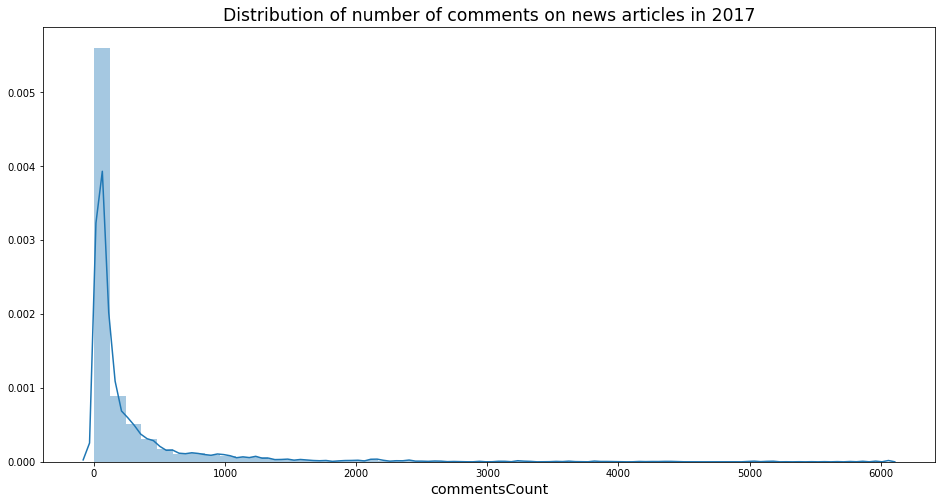

count     890.000000
mean      505.012360
std       409.356037
min         1.000000
25%       225.250000
50%       409.500000
75%       680.750000
max      4277.000000
Name: commentsCount, dtype: float64


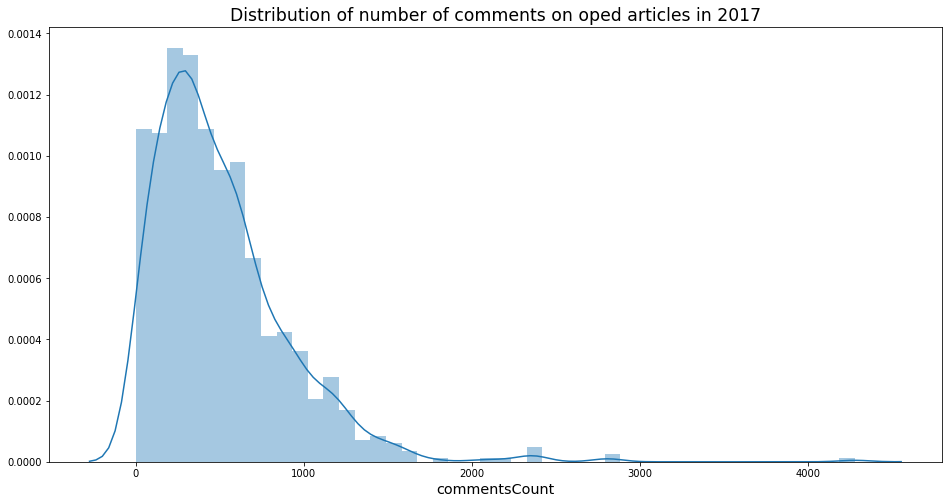

count    3210.000000
mean      152.821807
std       282.292855
min         1.000000
25%        14.000000
50%        50.000000
75%       150.000000
max      3823.000000
Name: commentsCount, dtype: float64


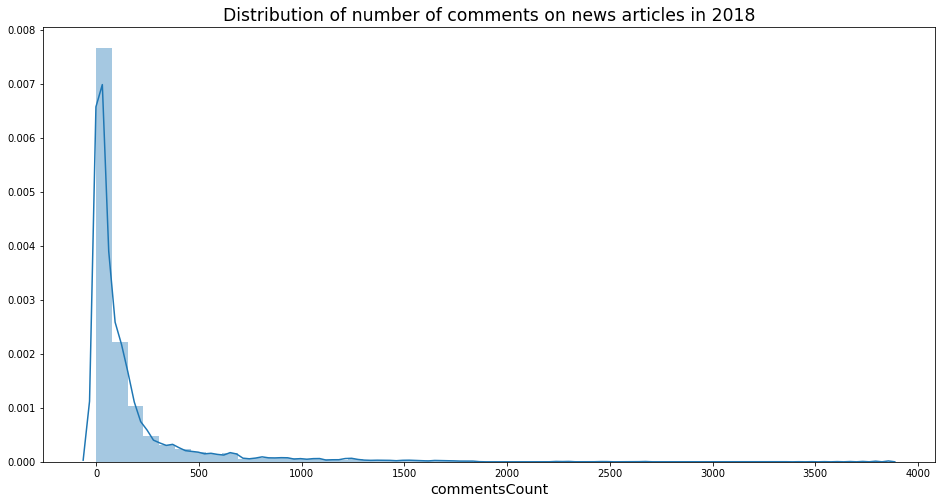

count     752.000000
mean      400.803191
std       343.499351
min         1.000000
25%       147.500000
50%       302.000000
75%       568.500000
max      2927.000000
Name: commentsCount, dtype: float64


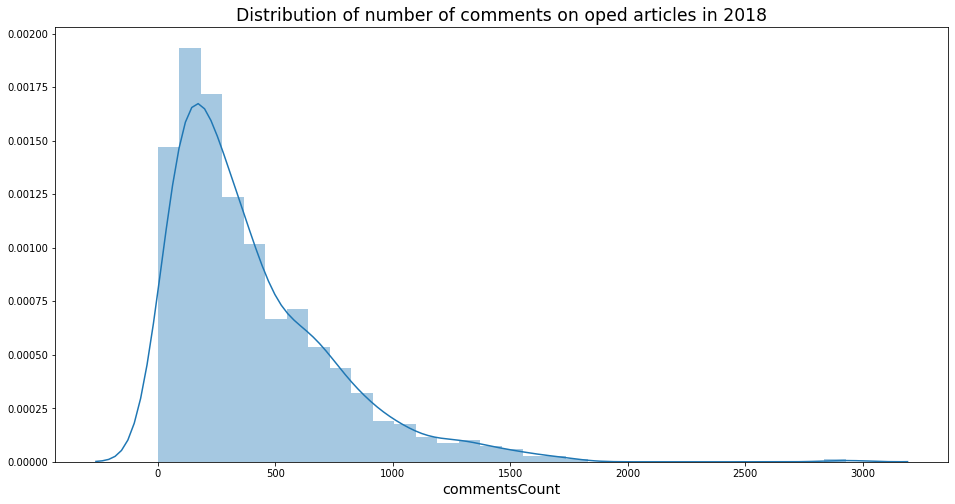

In [0]:
for year in years :
  for edtype in edtypes :
    grouped=var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].groupby('articleID')
    grouped_articles=grouped.commentID.count().reset_index().rename(columns = {'commentID': 'commentsCount'})
    articles=pd.merge(grouped_articles[['articleID','commentsCount']],var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)][['articleID',"keywords","sectionName","articleWordCount"]],on="articleID")
    print(articles.commentsCount.describe())
    mpl.rcParams['figure.figsize'] = (16, 8)
    sns.distplot(articles.commentsCount)
    plt.title("Distribution of number of comments on {} articles in {}".format(edtype.replace('-','').lower(),year))
    plt.show()

Alors qu'en 2017, l'écart-type du nombre de commentaires était plus grand pour les News, en 2018 le déséquilibre s'inverse. Il y a plus ou moins 100 commentaires d'écart entre les écart-types. Dans tous les cas, les articles d'opinions ont plus de commentaires que les articles de news pures. 

count    1343.000000
mean       78.852569
std       179.255246
min         1.000000
25%        10.000000
50%        28.000000
75%        71.000000
max      2145.000000
Name: commentsCount, dtype: float64


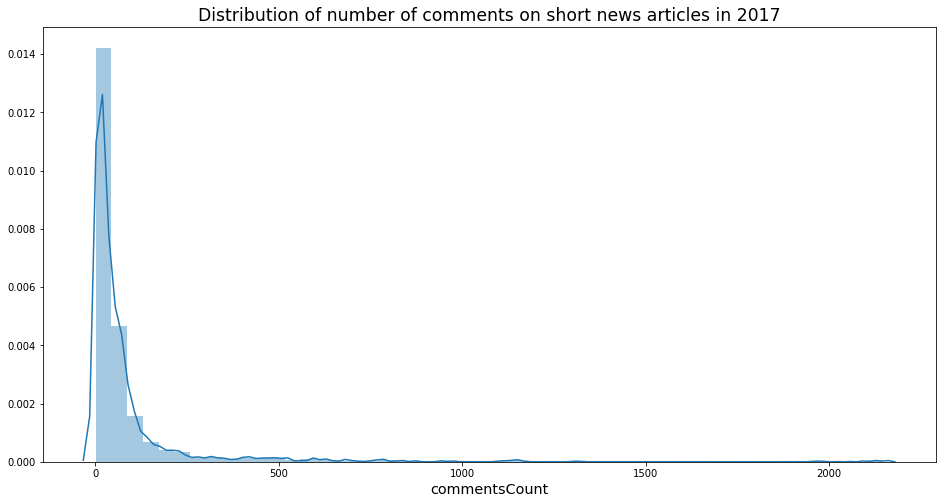

count    1386.000000
mean      379.734488
std       677.720370
min         1.000000
25%        42.000000
50%       131.000000
75%       383.750000
max      6024.000000
Name: commentsCount, dtype: float64


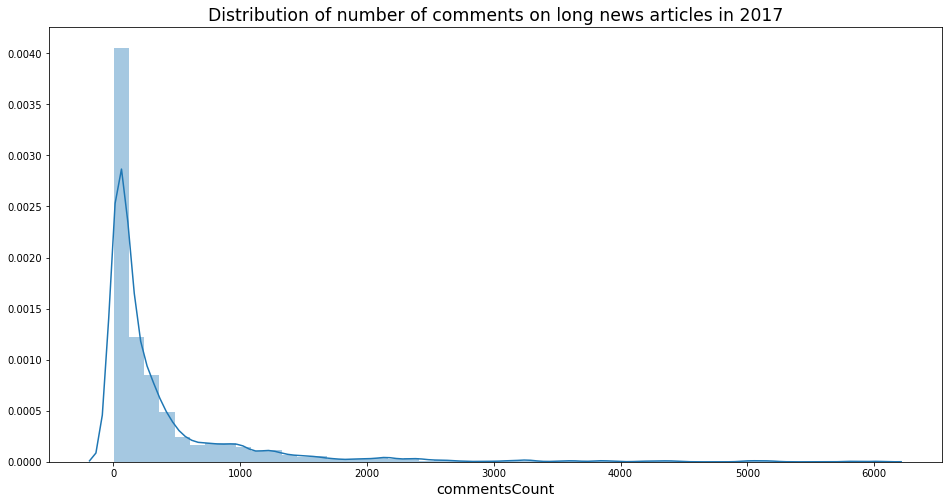

count     583.000000
mean      584.483705
std       423.526071
min         1.000000
25%       305.500000
50%       512.000000
75%       757.000000
max      4277.000000
Name: commentsCount, dtype: float64


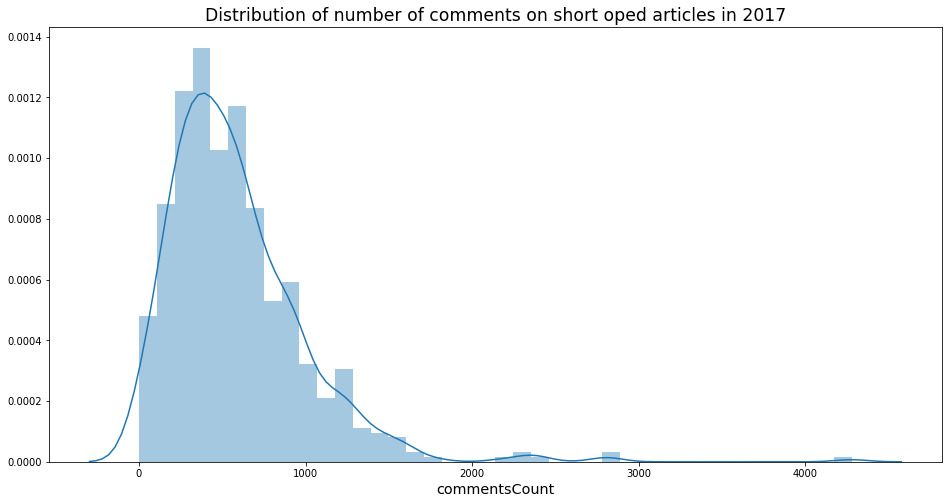

count     306.000000
mean      354.957516
std       333.051714
min         1.000000
25%       119.250000
50%       274.000000
75%       489.500000
max      2356.000000
Name: commentsCount, dtype: float64


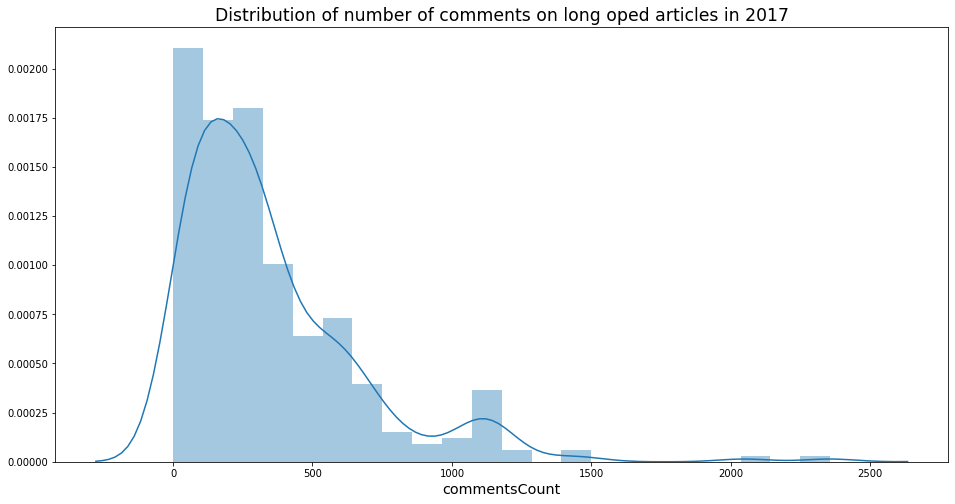

count    1253.000000
mean       66.695132
std       132.610800
min         1.000000
25%         6.000000
50%        20.000000
75%        74.000000
max      1230.000000
Name: commentsCount, dtype: float64


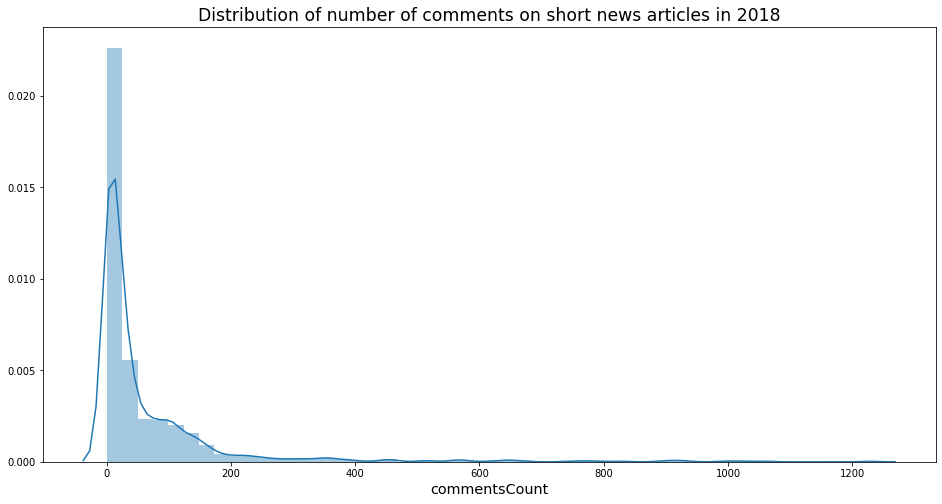

count    1950.000000
mean      208.578462
std       334.630178
min         1.000000
25%        28.000000
50%        87.000000
75%       210.000000
max      3823.000000
Name: commentsCount, dtype: float64


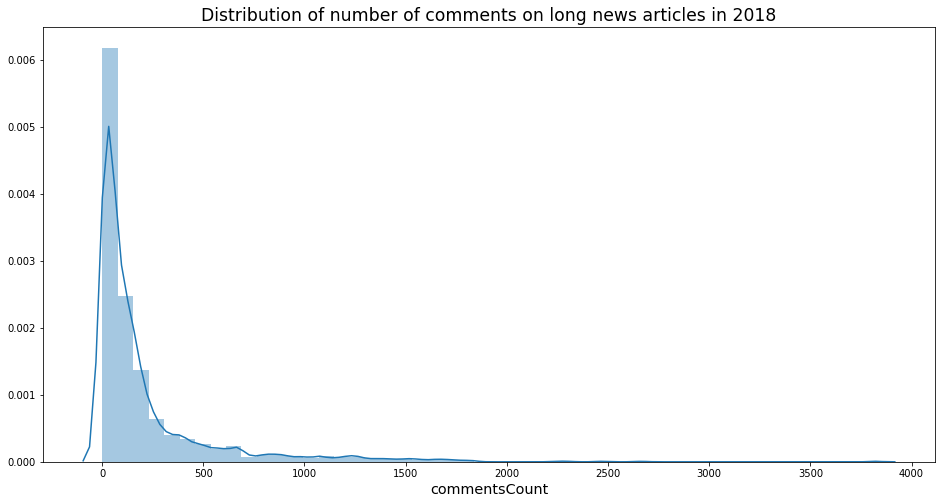

count     481.000000
mean      431.288981
std       356.729942
min         3.000000
25%       173.000000
50%       334.000000
75%       608.000000
max      2927.000000
Name: commentsCount, dtype: float64


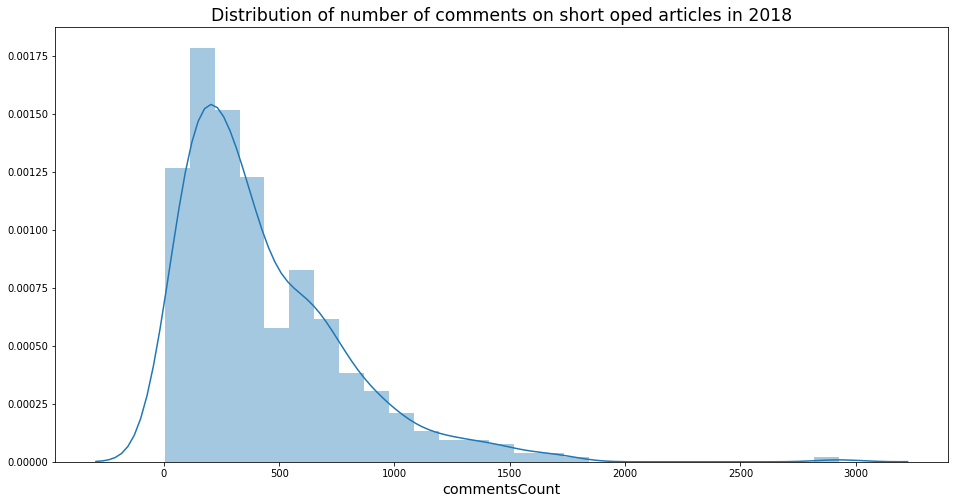

count     270.000000
mean      347.162963
std       312.516211
min         1.000000
25%       122.000000
50%       240.000000
75%       479.500000
max      1562.000000
Name: commentsCount, dtype: float64


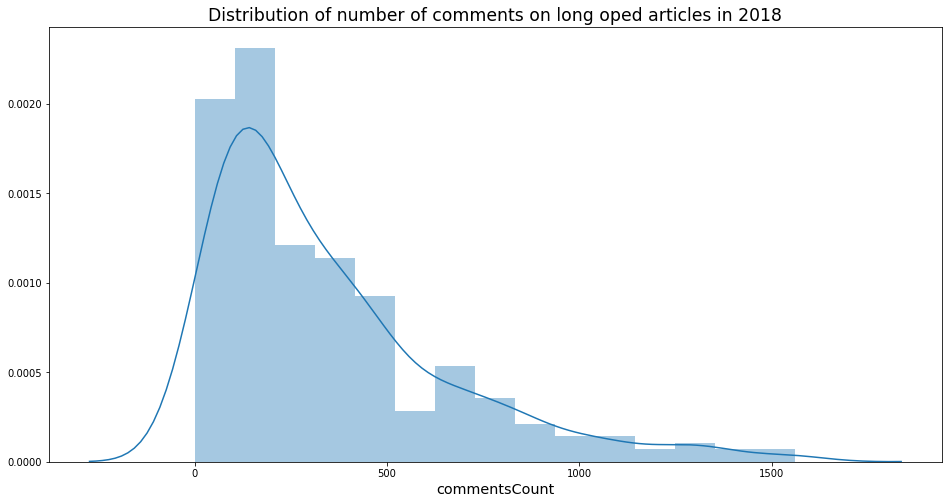

In [0]:
for year in years :
  for edtype in edtypes :
    for length in ['short','long'] :
      grouped=var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].groupby('articleID')
      grouped_articles=grouped.commentID.count().reset_index().rename(columns = {'commentID': 'commentsCount'})
      articles=pd.merge(grouped_articles[['articleID','commentsCount']],var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)][['articleID',"keywords","sectionName","articleWordCount"]],on="articleID")
      if length == 'short':
        articles=articles[articles['articleWordCount']<1000]
      else : 
        articles=articles[articles['articleWordCount']>1000]
      print(articles.commentsCount.describe())
      mpl.rcParams['figure.figsize'] = (16, 8)
      sns.distplot(articles.commentsCount)
      plt.title("Distribution of number of comments on {} {} articles in {}".format(length, edtype.replace('-','').lower(),year))
      plt.show()

Les articles de News sont très peu commentés lorsqu'ils sont courts, les lecteurs privilégiant seulement l'information. Ce n'est pas le cas pour les articles d'opinion qui sont plus commentés lorsqu'ils sont courts car plus facilement critiquables. Il n'y a pas de grands changements par rapport à l'année. Certaines thématiques incitent-elles plus à commenter que d'autres ?

### Concordance des thèmes journalistes - lecteurs

In [0]:
# LA CASE SUIVANTE PREND DU TEMPS A COMPILER (environ 15 min)

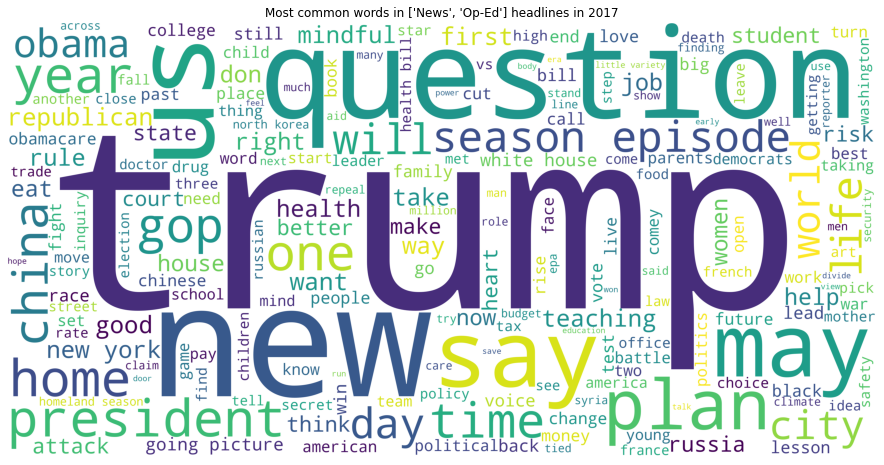

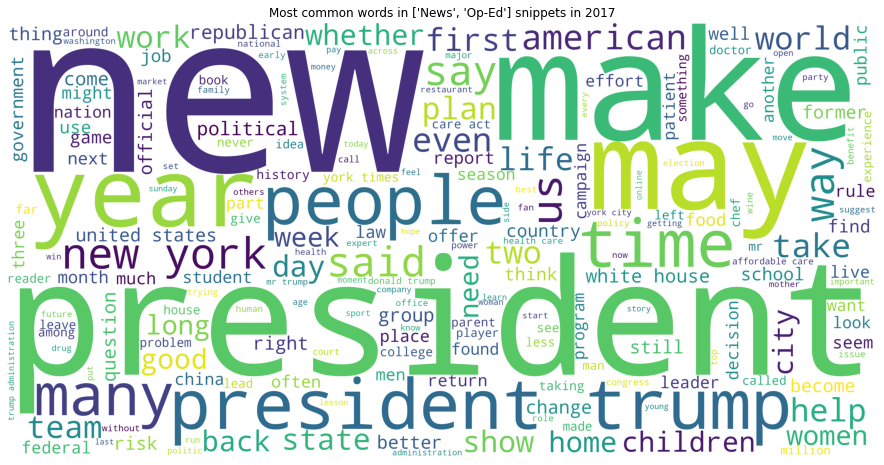

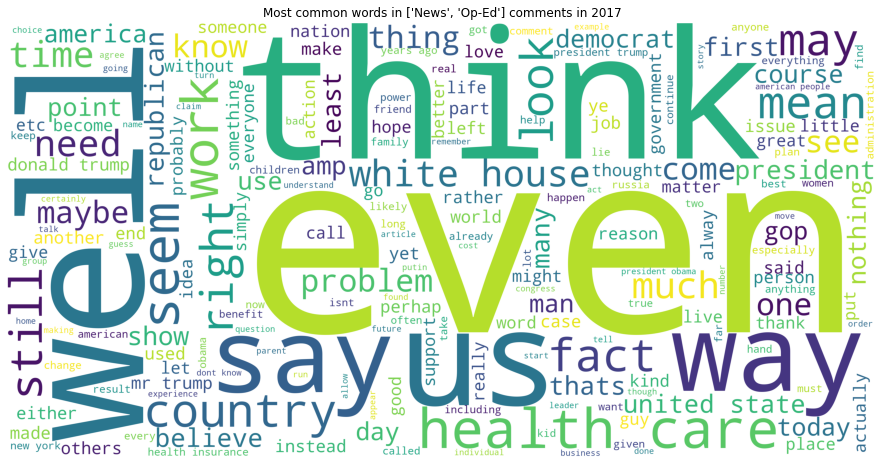

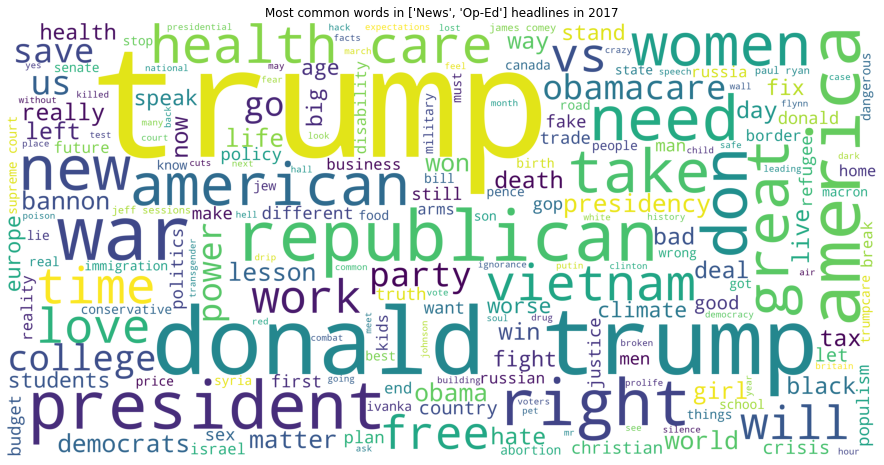

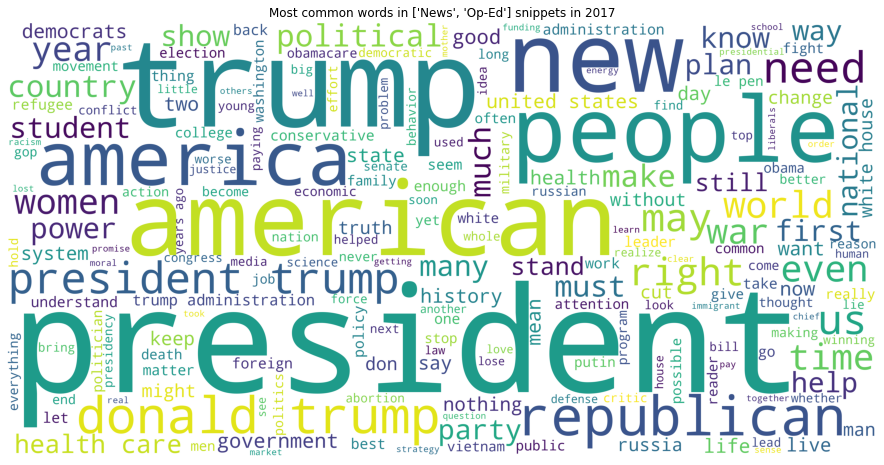

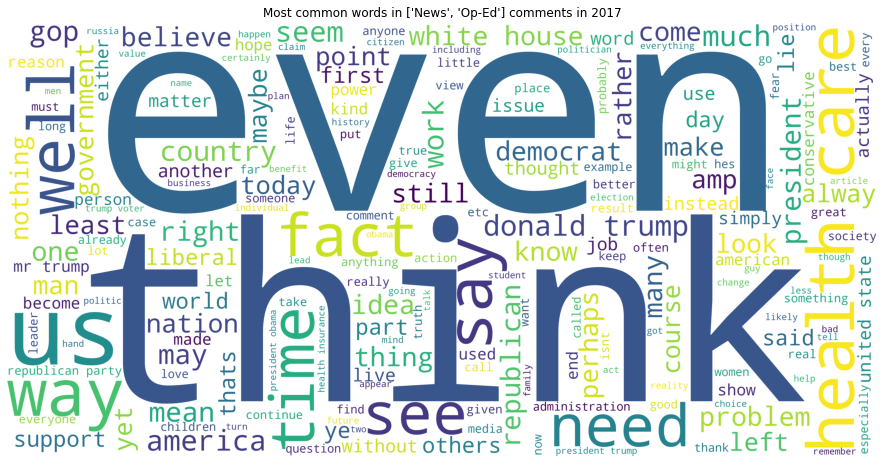

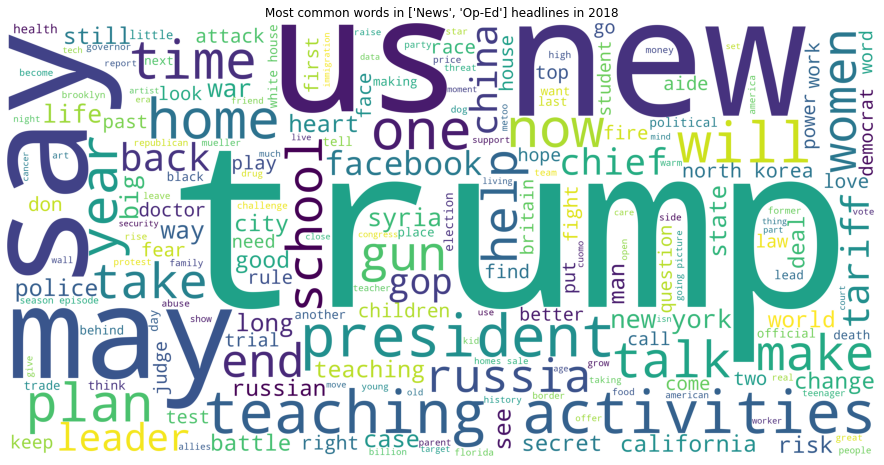

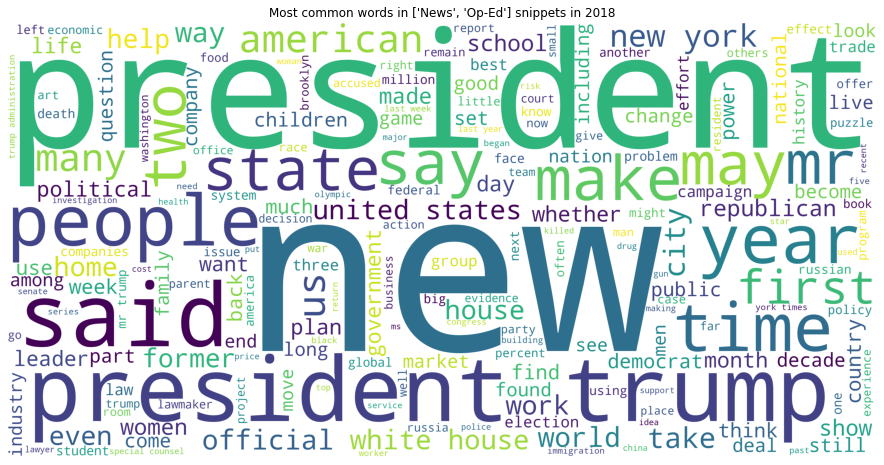

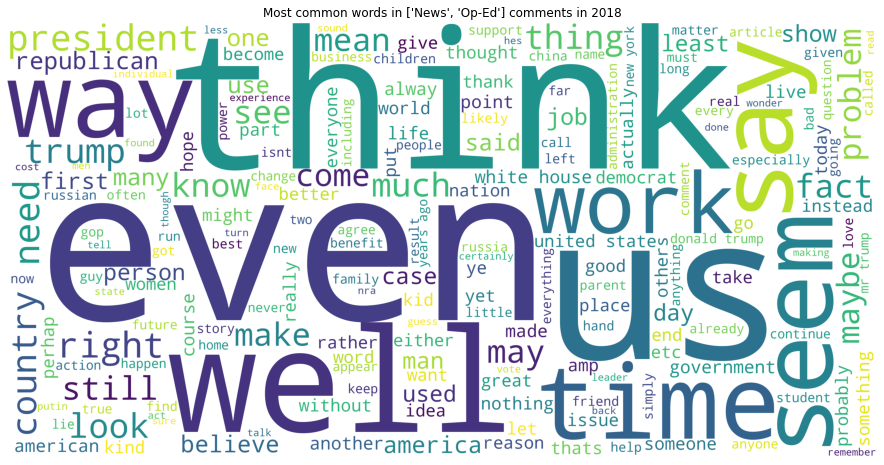

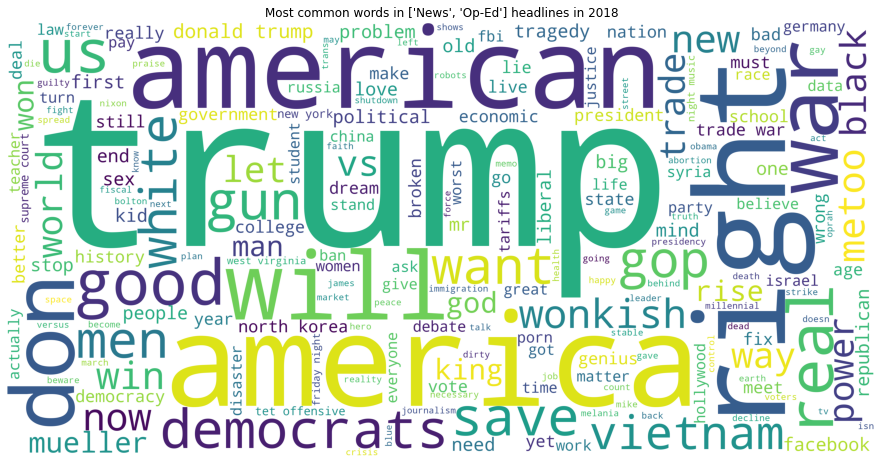

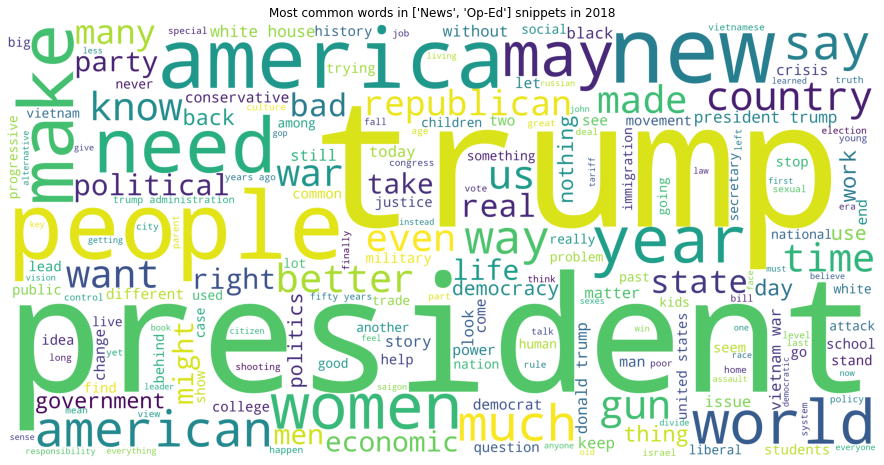

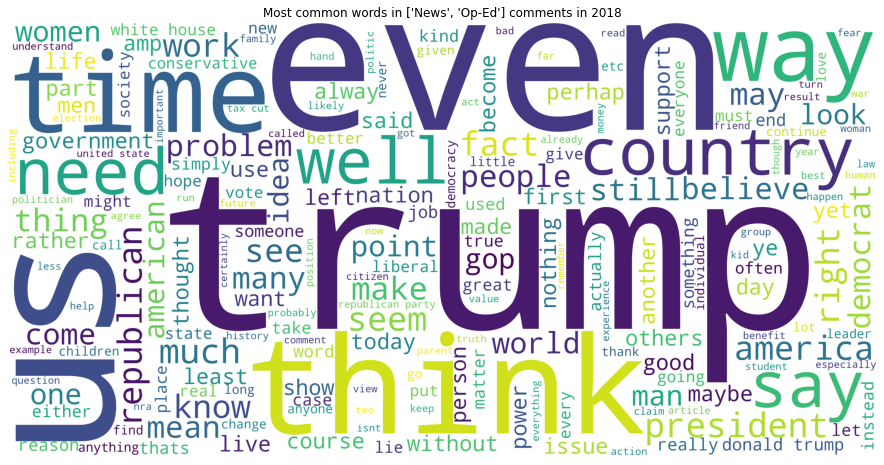

In [0]:
for year in years :

  for edtype in edtypes :

    start=time.time() 

    ## Headlines
    corpus=' '.join(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].headline_cleaned_string)
    title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(corpus)
    plt.figure(figsize=(16,8))
    plt.imshow(title_wordcloud)
    plt.axis('off')
    plt.title("Most common words in {} headlines in {}".format(edtype,year))
    plt.show()

    ## Snippets
    corpus=' '.join(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].snippet_cleaned_string)
    title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(corpus)
    plt.figure(figsize=(16,8))
    plt.imshow(title_wordcloud)
    plt.axis('off')
    plt.title("Most common words in {} snippets in {}".format(edtype,year))
    plt.show()

    ## Comments
    corpus=' '.join(var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].commentBody_cleaned_string)
    title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(corpus)
    plt.figure(figsize=(16,8))
    plt.imshow(title_wordcloud)
    plt.axis('off')
    plt.title("Most common words in {} comments in {}".format(edtype,year))
    plt.show()

    print('Total time for {} in {}: {} secs'.format(edtype,year,str((time.time() - start))))

Il est intéressant de voir que les problématiques évoquées par les journaux via leur headlines ou snippets, ne sont pas nécessairement les problématiques les plus commentées. On voit par exemple que le biais politique n'a été repris dans les commentaires qu'en 2018 par rapport à Donald Trump. Les commentaires mettent en avant d'autres problématiques moins évoquées comme le système de santé. Il y a-t-il une interaction, si ce n'est thématique, mais "sentimental" entre les journalistes et éditorialistes et leur lectorat ?

## Analyse sentiments & similarité


### Analyse sentiments

In [0]:
# LA CASE SUIVANTE PREND DU TEMPS A COMPILER (environ 20 min)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


       articleWordCount  sentiment_headline
count       2732.000000         2732.000000
mean        1131.818814            0.032101
std          994.097218            0.212641
min           26.000000           -1.000000
25%          574.000000            0.000000
50%         1011.000000            0.000000
75%         1350.250000            0.000000
max        12049.000000            1.000000
--- 5 random headlines with highest positive sentiment ---
Dinner, That Beautiful Dance

‘Homeland,’ Season 6, Episode 5: Quinn Is Not Your Ideal Babysitter

Just How Great Was That ‘Comet’?

Money and Power Alone Won’t Make America Great

Dinner, That Beautiful Dance

--- 5 random headlines with neutral  sentiment ---
Doctors: Inspections May Save Lives

If This Were an Overdose, Would You Help?

Don’t Expect to Lose Weight With Fitness Devices

Trump’s 2nd Nominee for Army Secretary Withdraws, Citing ‘Misleading’ Attacks

Expecting Trouble, California Picks Up Some Legal Muscle

--- 5 random hea

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       articleWordCount  sentiment_headline  sentiment_snippet
count       2732.000000         2732.000000        2732.000000
mean        1131.818814            0.032101           0.070970
std          994.097218            0.212641           0.225835
min           26.000000           -1.000000          -1.000000
25%          574.000000            0.000000           0.000000
50%         1011.000000            0.000000           0.000000
75%         1350.250000            0.000000           0.166667
max        12049.000000            1.000000           1.000000
--- 5 random snippets with highest positive sentiment ---
What country will win the worldwide race to dominate the robotics market?

Travis Kalanick’s drive to win in life has led to a pattern of risk-taking that has at times put his ride-hailing company on the brink of implosion.

A win over the Cowboys revitalizes Titletown.

Those mechanical cats that bring joy to those in nursing homes? Not everybody is fooled.

The Packers q

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       articleWordCount     commentID  ...        userID  sentiment_commentBody
count     649794.000000  6.497940e+05  ...  6.497940e+05          649794.000000
mean        1547.247649  2.187505e+07  ...  5.043838e+07               0.063773
std         1146.643757  5.283791e+05  ...  2.333686e+07               0.235257
min           26.000000  2.096381e+07  ...  1.045000e+03              -1.000000
25%         1124.000000  2.146976e+07  ...  3.319045e+07              -0.023810
50%         1343.000000  2.185963e+07  ...  5.817567e+07               0.033020
75%         1568.000000  2.227610e+07  ...  6.830550e+07               0.180132
max        12049.000000  2.682438e+07  ...  8.572519e+07               1.000000

[8 rows x 5 columns]
--- 5 random comments with highest positive sentiment ---
'Sickened' - perfect!!!!! Lol

The truth is that automation lost a great deal of those coal jobs.  One machine does the work of 100 men.  Companies now use 1 machine and up to 10 engineers down in the

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


       articleWordCount  sentiment_headline
count        890.000000          890.000000
mean        1027.700000            0.008366
std          370.984903            0.235149
min          225.000000           -1.000000
25%          821.000000            0.000000
50%          866.000000            0.000000
75%         1173.250000            0.000000
max         3770.000000            1.000000
--- 5 random headlines with highest positive sentiment ---
Judas, Tax Cuts and the Great Betrayal

Let’s Go for a Win on Opioids

Make China  Great Again

Don’t Let the Anti-L.G.B.T. Bigots Win

(It’s Great to) Suck at Something

--- 5 random headlines with neutral  sentiment ---
Justice Springs Eternal

Trump’s Mexican Shakedown

Trump  With  a Tail

Beltway Panic, Wall Street Zen

A Different Bargain on Race

--- 5 random headlines with negative sentiment ---
Paul Ryan Is Wrong on Freedom

Who Is a ‘Criminal’?

Who Is a ‘Criminal’?

Are  Your Sperm  in Trouble?

For the Forgotten African-America

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       articleWordCount  sentiment_headline  sentiment_snippet
count        890.000000          890.000000         890.000000
mean        1027.700000            0.008366           0.039808
std          370.984903            0.235149           0.259855
min          225.000000           -1.000000          -1.000000
25%          821.000000            0.000000           0.000000
50%          866.000000            0.000000           0.000000
75%         1173.250000            0.000000           0.133333
max         3770.000000            1.000000           1.000000
--- 5 random snippets with highest positive sentiment ---
They can take out terrorists and train armies. But they can’t win wars.

Do-something impulses and eco-cure boosterism turbocharged by government and subsidized business can do great harm.

Hold the Marseillaise! Time for the “Ode to Joy.”

Nothing brings this sports designer joy and inspiration like the blinding outfits of some 1970s baseball teams.

Canadians, who are pr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       articleWordCount     commentID  ...        userID  sentiment_commentBody
count     450229.000000  4.502290e+05  ...  4.502290e+05          450229.000000
mean         974.664509  2.188714e+07  ...  4.767990e+07               0.062115
std          333.400777  5.344206e+05  ...  2.284487e+07               0.218875
min          225.000000  2.096371e+07  ...  1.072000e+03              -1.000000
25%          815.000000  2.147030e+07  ...  3.037732e+07              -0.027778
50%          843.000000  2.188661e+07  ...  5.525872e+07               0.045284
75%          999.000000  2.231575e+07  ...  6.591578e+07               0.167811
max         3770.000000  2.682432e+07  ...  8.572191e+07               1.000000

[8 rows x 5 columns]
--- 5 random comments with highest positive sentiment ---
Great, why am I not relieved?

Brilliant, Charles.  And thank you for articulating the issues.

While I played b-ball, in 5th - 6th grade, I remember putting on my stirrup socks, and feeling that, des

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


       sentiment_headline
count         3211.000000
mean             0.027315
std              0.214956
min             -1.000000
25%              0.000000
50%              0.000000
75%              0.000000
max              1.000000
--- 5 random headlines with highest positive sentiment ---
Welcome to Zucktown

Threats, Pleas and a Golf Great: Nations’ Tactics for Tariff Relief

What Makes Someone a Great Leader?

Great Walls

Samantha Bee Celebrates Conor Lamb’s Win in Pennsylvania

--- 5 random headlines with neutral  sentiment ---
Variety: Cryptic Crossword

Something Extra With Every DVD

Should All Companies Require Anti-Bias Training for Employees?

For a Medical Opinion, a Word From Our Sitcom

Autocrats Steamroll Opponents With No Objections From U.S.

--- 5 random headlines with negative sentiment ---
‘Passionate Kissing’ Defense Clears Sprinter Accused of Doping

Trump’s Budget  Favors Military,  Inflating Deficit

Plunge in Value Makes the Frauds and Flaws in Virtual Curren

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       sentiment_headline  sentiment_snippet
count         3211.000000        3211.000000
mean             0.027315           0.068083
std              0.214956           0.226951
min             -1.000000          -1.000000
25%              0.000000           0.000000
50%              0.000000           0.000000
75%              0.000000           0.166667
max              1.000000           1.000000
--- 5 random snippets with highest positive sentiment ---
Which films do you hope will win an award?

Where do you go to experience the great outdoors? How do you spend your time there?

The artist Zulfikar Ali Bhutto, grandson and namesake of the founder of the Pakistan Peoples Party, is queer, Muslim and proud.

Experts recommend that babies sleep in the parents’ room — but not their bed — for up to a year, but that’s not ideal for all parents.

Who do you predict to win the tournament this year?

--- 5 random snippets with neutral  sentiment ---
The Polish law makes it a crime to blame

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       articleWordCount     commentID        userID  sentiment_commentBody
count     537781.000000  5.377810e+05  5.377810e+05          537781.000000
mean        1464.593243  2.623235e+07  5.222962e+07               0.068351
std          984.180785  4.488643e+05  2.395902e+07               0.235024
min           28.000000  2.539047e+07  1.045000e+03              -1.000000
25%         1087.000000  2.586041e+07  3.510116e+07              -0.019643
50%         1320.000000  2.628188e+07  5.943861e+07               0.034571
75%         1559.000000  2.662115e+07  6.956662e+07               0.187500
max        16336.000000  2.694126e+07  8.585631e+07               1.000000
--- 5 random comments with highest positive sentiment ---
Brilliant!

The NYT and WaPo: Competency &amp; spine.<br/><br/>Oh, joy...!

Fair and equitable policy produces the best results.

Before all the haters start in, let me say, this is beautiful.

Dowd knows he can't win this case now. There is no way to defend a loudmo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


       sentiment_headlines  sentiment_headline
count           752.000000          752.000000
mean              0.024254            0.024254
std               0.242921            0.242921
min              -1.000000           -1.000000
25%               0.000000            0.000000
50%               0.000000            0.000000
75%               0.000000            0.000000
max               0.900000            0.900000
--- 5 random headlines with highest positive sentiment ---
I Quit Twitter and It Feels Great

Is This Dog Actually Happy?

Will Democrats Win the House? Ask Texas

Robots Can’t Vote, but They Helped Elect Trump

How China Used Schools to Win Over Hanoi

--- 5 random headlines with neutral  sentiment ---
Scandal-Ridden Scoundrel

The Ivanka Of North Korea? Oh, Please

The Myth of Eugene McCarthy

Beware of Devin Nunes’s Next Move

The Supreme Court’s Power Play Against Labor

--- 5 random headlines with negative sentiment ---
How to Speak Grief

Select the Worst Trump Min

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       sentiment_headlines  sentiment_headline  sentiment_snippet
count           752.000000          752.000000         752.000000
mean              0.024254            0.024254           0.038179
std               0.242921            0.242921           0.255148
min              -1.000000           -1.000000          -1.000000
25%               0.000000            0.000000           0.000000
50%               0.000000            0.000000           0.000000
75%               0.000000            0.000000           0.136364
max               0.900000            0.900000           1.000000
--- 5 random snippets with highest positive sentiment ---
If immunotherapy worked most of the time, this would be an unambiguously happy story. But it doesn’t.

Putin’s victory on Sunday is a certainty, but what other victories might he win in Europe?

At Loyola, our poetry workshop was energized by our team’s win, not overshadowed by it.

The U.S. needs an alternative to a free-trade system that has ho

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       articleWordCount     commentID        userID  sentiment_commentBody
count     322459.000000  3.224590e+05  3.224590e+05          322459.000000
mean        1028.948731  2.618140e+07  4.948630e+07               0.070387
std          423.161677  4.430730e+05  2.336535e+07               0.218588
min           90.000000  2.538917e+07  1.045000e+03              -1.000000
25%          832.000000  2.580636e+07  3.244163e+07              -0.019055
50%          864.000000  2.620098e+07  5.685733e+07               0.052381
75%         1100.000000  2.655218e+07  6.713791e+07               0.177083
max         3425.000000  2.693959e+07  8.584727e+07               1.000000
--- 5 random comments with highest positive sentiment ---
Great piece; thank you.

I think that should be worded; "just annoyance that we didn't acknowledge what a great guy he is."  

I fear a taxpayer revolt if law enforcement intelligence (such as a master's degree) is required for application of carry a firearm.<br/>Sec

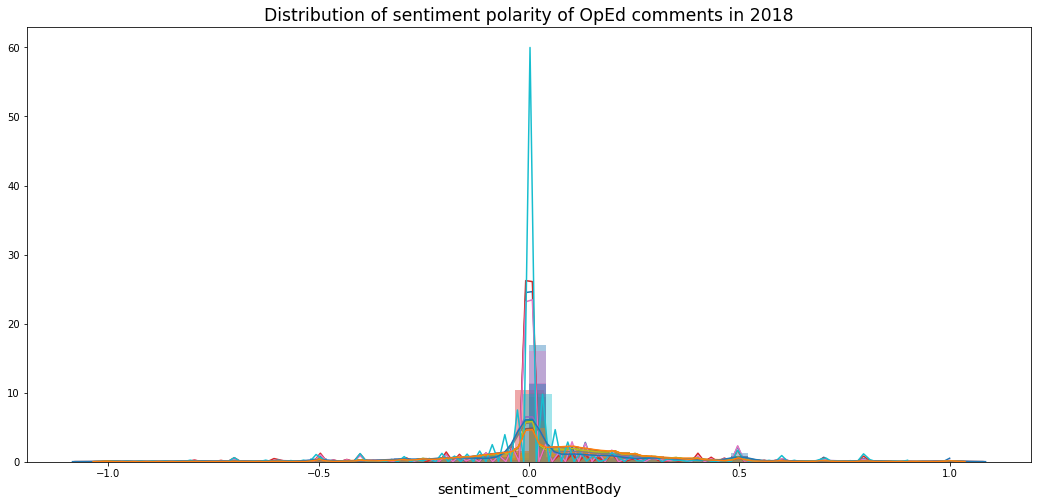

In [0]:
# Prédictions sentimentales

for year in years :

  for edtype in edtypes :

    start=time.time()

    ## Headlines

    ### Prediction & Description
    var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)]["sentiment_headline"]= var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].headline_cleaned_string.map(lambda text: TextBlob(text).sentiment.polarity)
    var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].to_csv("articles_{}_{}_headline.csv".format(edtype.replace('-','').lower(),year))
    print(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].describe())
    ### A few elements
    print("--- 5 random headlines with highest positive sentiment ---")
    cL=var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].loc[(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_headline<1) & (var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_headline>0.75),["headline"]].sample(5).values      
    show_first_element(cL)
    print("--- 5 random headlines with neutral  sentiment ---")
    cL=var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].loc[var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_headline==0,["headline"]].sample(5).values
    show_first_element(cL)
    print("--- 5 random headlines with negative sentiment ---")
    cL=var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].loc[var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_headline<0,["headline"]].sample(5).values
    show_first_element(cL)
    ### The whole distribution
    mpl.rcParams['figure.figsize'] = (18, 8)
    mpl.rcParams['axes.titlesize'] = 'xx-large'
    mpl.rcParams['axes.labelsize'] = 'x-large'
    sns.distplot(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_headline)
    plt.title("Distribution of sentiment polarity of {} headlines in {}".format(edtype.replace('-',''),year))
    plt.show()
    
    ## Snippets

    ### Prediction & Description
    var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)]["sentiment_snippet"]= var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].snippet_cleaned_string.map(lambda text: TextBlob(text).sentiment.polarity)
    var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].to_csv("articles_{}_{}_snippet.csv".format(edtype.replace('-','').lower(),year))
    print(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].describe())
    ### A few elements
    print("--- 5 random snippets with highest positive sentiment ---")
    cL=var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].loc[(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_snippet<1) & (var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_snippet>0.75),["snippet"]].sample(5).values      
    show_first_element(cL)
    print("--- 5 random snippets with neutral  sentiment ---")
    cL=var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].loc[var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_snippet==0,["snippet"]].sample(5).values
    show_first_element(cL)
    print("--- 5 random snippets with negative sentiment ---")
    cL=var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].loc[var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_snippet<0,["snippet"]].sample(5).values
    show_first_element(cL)
    ### The whole distribution
    mpl.rcParams['figure.figsize'] = (18, 8)
    mpl.rcParams['axes.titlesize'] = 'xx-large'
    mpl.rcParams['axes.labelsize'] = 'x-large'
    sns.distplot(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_snippet)
    plt.title("Distribution of sentiment polarity of {} snippets in {}".format(edtype.replace('-',''),year))
    plt.show()
    
    ## Comments

    ### Prediction & Description
    var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)]["sentiment_commentBody"]= var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].commentBody_cleaned_string.map(lambda text: TextBlob(text).sentiment.polarity)
    var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].to_csv("comments_{}_{}.csv".format(edtype.replace('-','').lower(),year))
    print(var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].describe())
    ### A few elements
    print("--- 5 random comments with highest positive sentiment ---")
    cL=var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].loc[(var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_commentBody<1) & (var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_commentBody>0.75),["commentBody"]].sample(5).values      
    show_first_element(cL)
    print("--- 5 random comments with neutral  sentiment ---")
    cL=var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].loc[var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_commentBody==0,["commentBody"]].sample(5).values
    show_first_element(cL)
    print("--- 5 random comments with negative sentiment ---")
    cL=var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].loc[var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_commentBody<0,["commentBody"]].sample(5).values
    show_first_element(cL)
    ### The whole distribution
    mpl.rcParams['figure.figsize'] = (18, 8)
    mpl.rcParams['axes.titlesize'] = 'xx-large'
    mpl.rcParams['axes.labelsize'] = 'x-large'
    sns.distplot(var['comments_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_commentBody)
    plt.title("Distribution of sentiment polarity of {} comments in {}".format(edtype.replace('-',''),year))
    plt.show()

    print('Total time for {} in {}: {} secs'.format(edtype,year,str((time.time() - start))))

headline_sentiment: mean=0.032 stdv=0.213
snippet_sentiment: mean=0.071 stdv=0.226


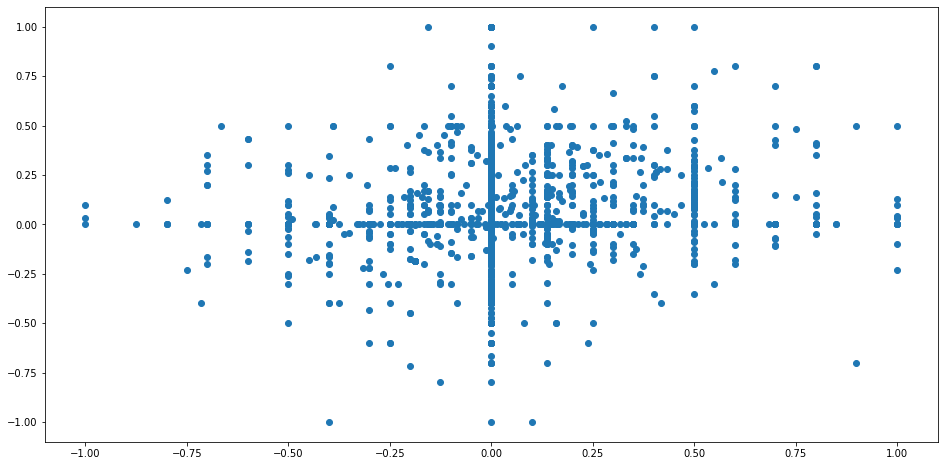

headline_sentiment: mean=0.008 stdv=0.235
snippet_sentiment: mean=0.040 stdv=0.260


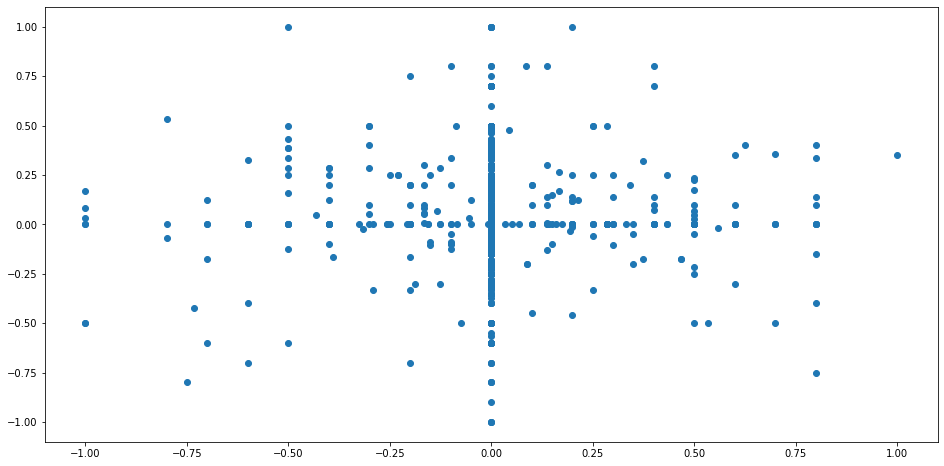

headline_sentiment: mean=0.027 stdv=0.215
snippet_sentiment: mean=0.068 stdv=0.227


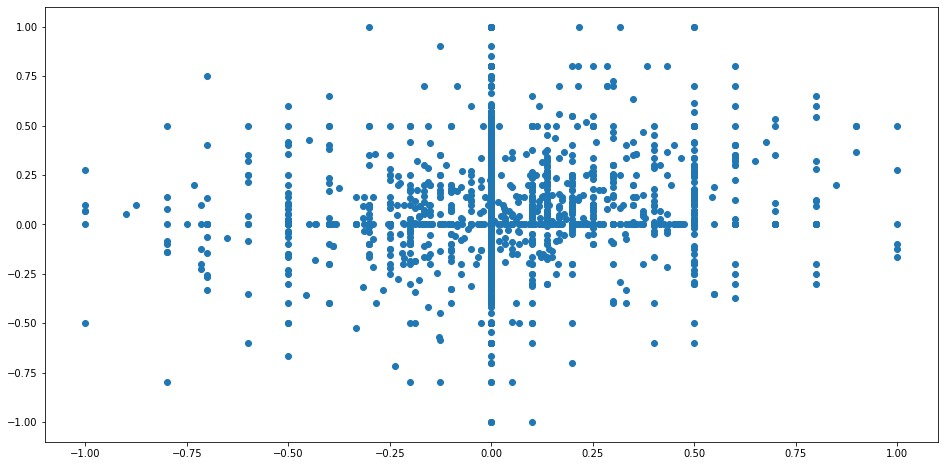

headline_sentiment: mean=0.024 stdv=0.243
snippet_sentiment: mean=0.038 stdv=0.255


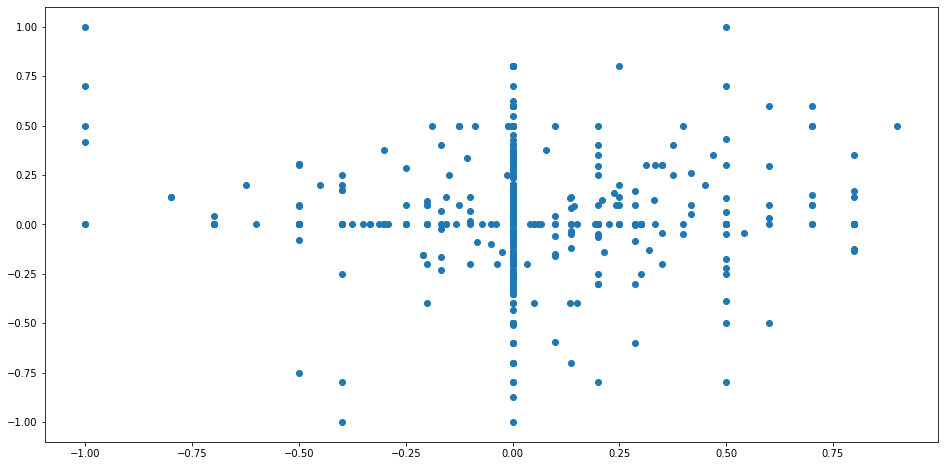

In [0]:
# Comment caractérisé les articles, par leur titre ou bien leur chapô ?

for year in years :
  for edtype in edtypes :
    # summarize
    print('headline_sentiment: mean=%.3f stdv=%.3f' % (mean(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_headline), std(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_headline)))
    print('snippet_sentiment: mean=%.3f stdv=%.3f' % (mean(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_snippet), std(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_snippet)))
    # plot
    plt.scatter(var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_headline, var['articles_{}_{}'.format(edtype.replace('-','').lower(),year)].sentiment_snippet)
    plt.show()

On remarque que les sentiments des headlines et des snippets ne sont que peu corrélés. De plus les headlines sont plus polarisées et négatives, nous allons nous concentrer sur leur étude.

### Analyse similarité

In [0]:
# On sélectionne une sous-catégorie de mots que l'on a vu beaucoup ressortir

concepts=["trump","republicans","democrats","congress","tax","immigration"]
concepts_column=[]
for i in range(len(concepts)):
  for j in range(2):
    concepts_column.append(concepts[i])

qualities=["good","bad"]
qualities_column=[]
for i in range(len(concepts)):
  for j in range(2):
    qualities_column.append(qualities[j])

In [0]:
# LA CASE SUIVANTE PREND DU TEMPS A COMPILER (environ 20 min)

In [0]:
for year in years :

  for edtype in edtypes :

    var['comparison_{}_{}'.format(edtype.replace('-','').lower(),year)] = pd.DataFrame({"concept":concepts_column,"quality":qualities_column})

    for wrote,content in zip([written[0]],[contents[0]]):

      start=time.time()

      var['{}{}{}'.format(edtype.replace('-',''),wrote.capitalize(),str(year)[-2:])]=Word2Vec(var['{}_{}_{}'.format(content.lower(),edtype.replace('-','').lower(),year)]['{}_cleaned_list'.format(wrote)],size=100,window=5,min_count=3,workers=cpu)
      var['{}{}{}'.format(edtype.replace('-',''),wrote.capitalize(),str(year)[-2:])].train(var['{}_{}_{}'.format(content.lower(),edtype.replace('-','').lower(),year)]['{}_cleaned_list'.format(wrote)],total_examples=len(var['{}_{}_{}'.format(content.lower(),edtype.replace('-','').lower(),year)]['{}_cleaned_list'.format(wrote)]),epochs=10)
      var['{}{}{}_wv'.format(edtype.replace('-',''),wrote.capitalize(),str(year)[-2:])]=var['{}{}{}'.format(edtype.replace('-',''),wrote.capitalize(),str(year)[-2:])].wv
      domains=['{} '.format(edtype, content, year)]
      wvs=[var['{}{}{}_wv'.format(edtype.replace('-',''),wrote.capitalize(),str(year)[-2:])]]
      var['comparison_{}_{}'.format(edtype.replace('-','').lower(),year)]['Similarity according to {} model'.format(wrote)] = var['comparison_{}_{}'.format(edtype.replace('-','').lower(),year)].apply(lambda x: compute_sim(x["concept"], x["quality"], var['{}{}{}'.format(edtype.replace('-',''),wrote.capitalize(),str(year)[-2:])]), axis=1)

      print('Total time for {} {} in {}: {} secs'.format(edtype,wrote, year,str((time.time() - start))))
   

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Total time for News headline in 2017: 0.5275955200195312 secs
Total time for Op-Ed headline in 2017: 0.13888263702392578 secs
Total time for News headline in 2018: 0.685758113861084 secs
Total time for Op-Ed headline in 2018: 0.13656210899353027 secs


## Evaluation des modèles

### Analyse quantitative (Blob)

La base sur laquelle nous avons travaillé (10 000 articles) n'est pas publique, elle contient des articles de presse et leur note sentimentale en fonction de leur texte. Nous avons bien effectué nos calculs avec cette base, mais nous vous présentons une base anonymisée où les textes ont été désapariés de leurs notes.

In [0]:
!wget -O database/sentiments-anonymised.csv https://www.dropbox.com/s/n4nwrhzmjkx0q0s/database-sentiment-anonymised.csv?dl=0
news_sentiments_2020=pd.read_csv('database/sentiments-anonymised.csv')

In [0]:
# preprocessing
news_sentiments_2020['body_cleaned_list']=news_sentiments_2020['body'].apply(lambda row: clean(row,stop,punctuation,punctuation_list))
news_sentiments_2020['body_cleaned_string']=news_sentiments_2020['body_cleaned_list'].apply(lambda row: ' '.join(row))
# prédiction
news_sentiments_2020["sentiment_guessed"]= news_sentiments_2020.body_cleaned_string.map(lambda text: TextBlob(text).sentiment.polarity)
news_sentiments_2020["sentiment_guessed_classified"]= news_sentiments_2020.sentiment_guessed.apply(sentiment_classifier)
news_sentiments_2020["sentiment_classified"]= news_sentiments_2020.sentiment.apply(sentiment_classifier)

              precision    recall  f1-score   support

    negative       0.27      0.01      0.01      1211
     neutral       0.87      0.98      0.92      8678
    positive       0.02      0.04      0.03       111

    accuracy                           0.85     10000
   macro avg       0.39      0.34      0.32     10000
weighted avg       0.79      0.85      0.80     10000



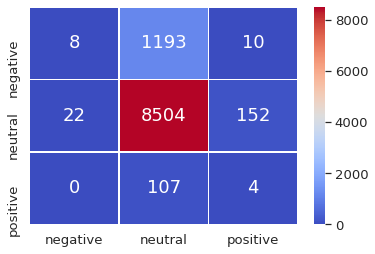

In [0]:
show_eval(news_sentiments_2020["sentiment_classified"],news_sentiments_2020["sentiment_guessed_classified"])

En s'intéressant au F1-score, on remarque que notre modèle est assez bon pour évaluer les éléments neutres, moins pour évaluer les éléments polarisés

# Analyse qualitative avec Word2Vec — travail sur 2017

News Analysis — 2017

In [0]:
# On nettoie 

import nltk 
from nltk.corpus import stopwords
set(stopwords.words("english"))
from nltk.tokenize import word_tokenize 
stop = stopwords.words('english')

filtered_headlines=articles_news_2017["headline"].str.lower().apply(lambda x:" ".join([word for word in x.split() if word not in (stop)]))
filtered_headlines=filtered_headlines.str.replace('[^\w\s]','')

In [20]:
# On tokenize
articles_news_2017_clean=tokenize_corpus(filtered_headlines,tweets=False)

100%|██████████| 2732/2732 [00:00<00:00, 12494.36it/s]


In [0]:
# On train notre modèle word2vec

In [21]:
start_time=time.time()
print("Training the article W2V")
news17=Word2Vec(articles_news_2017_clean,size=100,window=5,min_count=3,workers=cpu)
news17.train(articles_news_2017_clean,total_examples=len(articles_news_2017.headline),epochs=10)
news17_wv=news17.wv

elapsed_time=time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

Training the article W2V


'00:00:00'

In [38]:
# Génération de clusters

nltk.download('punkt')

def clustering_on_wordvecs(word_vectors, num_clusters):
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
Z=news17.wv.syn0
centers, clusters = clustering_on_wordvecs(Z, 100)
centroid_map = dict(zip(news17.wv.index2word, clusters))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [0]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df

In [67]:
top_words = get_top_words(news17.wv.index2word, 10, centers, Z);
top_words

Cluster #0 Cluster #1 Cluster #2  ... Cluster #97 Cluster #98 Cluster #99
1         tax        gop        win  ...       fight        city       white
2        much      court       bill  ...      really        news       times
3      things        the       move  ...         epa         war        move
4       judge     battle    lessons  ...       world    security      leader
5   americans    another       dont  ...          it      battle    teaching
6        like       mind       news  ...   political        year      policy
7          it        law    looking  ...       think        save          it
8    american        epa     rights  ...       judge         the      family
9        move        old     battle  ...     mindful         fbi       judge
10     health     repeal     better  ...      across       black        love

[10 rows x 100 columns]

In [0]:
##### Même travail sur nos commentaires pour l'année 2017

In [0]:
filtered_comments=comments_news_2017["commentBody"].str.lower().apply(lambda x:" ".join([word for word in x.split() if word not in (stop)]))
filtered_comments=filtered_comments.str.replace('[^\w\s]','')

In [0]:
comments_news_2017_clean=tokenize_corpus(filtered_comments,tweets=False)

In [31]:
start=time.time()

print("Training the article W2V")
cnews17=Word2Vec(comments_news_2017_clean,size=100,window=5,min_count=3,workers=cpu)
print('Total time: ' + str((time.time() - start)) + ' secs')

cnews17.train(comments_news_2017_clean,total_examples=len(comments_news_2017.commentBody),epochs=10)
cnews17_wv=cnews17.wv

Training the article W2V
Total time: 148.51911783218384 secs


In [47]:
# Clustering sur les commentaires 2017 

Z=cnews17.wv.syn0
centers, clusters = clustering_on_wordvecs(Z, 50)
centroid_map = dict(zip(cnews17.wv.index2word, clusters))
top_words = get_top_words(cnews17.wv.index2word, 1000, centers, Z);
top_words

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Cluster #0   Cluster #1  ...         Cluster #48   Cluster #49
1            offences    dysbiosis  ...         challengers        twobit
2        manslaughter   pathogenic  ...           nonvoters     puppeteer
3        prosecutable    berberine  ...          incumbents     miscreant
4             offence       peptic  ...            caucuses   loudmouthed
5           felonious  doxycycline  ...       gubernatorial    puppeteers
...               ...          ...  ...                 ...           ...
996   intellectuality        yogic  ...           nowbrbrso      superego
997        bernandino      bactrim  ...           agendabri      eminence
998          vagrants          oai  ...  immediatelybrstart    daddyinlaw
999       herebrfirst  metabolisms  ...      positionsbrthe     antimedia
1000      dehumanizes  capillaries  ...           nonracist  neochristian

[1000 rows x 50 columns]

In [32]:
#####Closest to — a comparison between headlines and comments 

domains = ['headline', 'comments'] 
wvs = [news17 , cnews17]

def closest_to(w, n=10):
  for wv, domain in zip(wvs, domains):
    if w in wv:
      closest_ws =[w[0] for w in wv.most_similar(w, topn=n)]
      print("According to {}, the closest {}, words to \"{}\" " 
      "are: \n {}".format(domain, n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the {} vocabulary".format(domain))

print(closest_to("trump"))
print(closest_to("republicans"))
print(closest_to("democrats"))
print(closest_to("congress"))
print(closest_to("tax"))
print(closest_to("immigration"))


According to headline, the closest 10, words to "trump" are: 
 "new",
 then "us",
 then "one",
 then "may",
 then "questions",
 then "says",
 then "first",
 then "plan",
 then "president",
 then "trumps"
According to comments, the closest 10, words to "trump" are: 
 "djt",
 then "dt",
 then "trumps",
 then "brbrtrump",
 then "tump",
 then "trumpster",
 then "him",
 then "presidentelect",
 then "obama",
 then "mrtrump"
None
According to headline, the closest 10, words to "republicans" are: 
 "2",
 then "trump",
 then "us",
 then "new",
 then "trumps",
 then "season",
 then "first",
 then "may",
 then "for",
 then "want"
According to comments, the closest 10, words to "republicans" are: 
 "democrats",
 then "repubs",
 then "gop",
 then "dems",
 then "rs",
 then "brbrrepublicans",
 then "gopers",
 then "republican",
 then "conservatives",
 then "constituents"
None
According to headline, the closest 10, words to "democrats" are: 
 "trump",
 then "new",
 then "us",
 then "says",
 then "ques

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [93]:
# Comparaison similarités avec good/bad 

choice_of_words=["trump","trump","republicans","republicans","democrats","democrats","congress","congress","tax","tax","immigration","immigration"]
qualitative_words=["good","bad"]*6

comparison_headline_comments_news_17=pd.DataFrame({"word 1":choice_of_words,
                        "qualitative word":qualitative_words})

comparison_headline_comments_news_17["similarity according to headlines model"]=comparison_headline_comments_news_17.apply(lambda x: compute_sim(x["word 1"], x["qualitative word"], news17), axis=1)
comparison_headline_comments_news_17["similarity according to comments model"]=comparison_headline_comments_news_17.apply(lambda x: compute_sim(x["word 1"], x["qualitative word"], cnews17), axis=1)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [94]:
comparison_headline_comments_news_17

word 1  ... similarity according to comments model
0         trump  ...                              -0.024125
1         trump  ...                               0.083021
2   republicans  ...                               0.001266
3   republicans  ...                               0.011573
4     democrats  ...                               0.016807
5     democrats  ...                               0.031248
6      congress  ...                               0.006949
7      congress  ...                              -0.059040
8           tax  ...                              -0.053943
9           tax  ...                              -0.080672
10  immigration  ...                              -0.060051
11  immigration  ...                              -0.011422

[12 rows x 4 columns]

• Editorial Analysis — 2017

In [0]:
### Headlines _ editorial

filtered_headlines=articles_oped_2017["headline"].str.lower().apply(lambda x:" ".join([word for word in x.split() if word not in (stop)]))
filtered_headlines=filtered_headlines.str.replace('[^\w\s]','')


In [49]:
articles_oped_2017_clean=tokenize_corpus(filtered_headlines,tweets=False)



100%|██████████| 890/890 [00:00<00:00, 12268.60it/s]


In [50]:
#Training
start_time=time.time()
print("Training the article W2V")
oped17=Word2Vec(articles_oped_2017_clean,size=100,window=5,min_count=3,workers=cpu)
oped17.train(articles_oped_2017_clean,total_examples=len(articles_oped_2017.headline),epochs=10)
oped17_wv=oped17.wv

elapsed_time=time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))


Training the article W2V


'00:00:00'

In [66]:
#Clustering

Z=oped17.wv.syn0
centers, clusters = clustering_on_wordvecs(Z, 100)
centroid_map = dict(zip(oped17.wv.index2word, clusters))

top_words = get_top_words(oped17.wv.index2word, 10, centers, Z);
top_words

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Cluster #0 Cluster #1 Cluster #2  ... Cluster #97   Cluster #98 Cluster #99
1     country        its      paris  ...      canada            us       black
2         pet      death       free  ...        hell         women         way
3       march       love  ignorance  ...     silence          plan   ignorance
4       child      takes        box  ...       times  presidential       crazy
5    business        red      world  ...       facts         takes         new
6       fight   abortion      women  ...        home        lesson        lost
7       facts       cant       keep  ...        road          mind       facts
8        case    silence     behind  ...       child          love        want
9   ignorance       feel      takes  ...        save          jews       child
10        get      girls        tax  ...     refugee       russian         men

[10 rows x 100 columns]

In [0]:
## Commentaires - Editorial 2017

In [0]:
filtered_comments=comments_oped_2017["commentBody"].str.lower().apply(lambda x:" ".join([word for word in x.split() if word not in (stop)]))
filtered_comments=filtered_comments.str.replace('[^\w\s]','')


In [0]:
comments_oped_2017_clean=tokenize_corpus(filtered_comments,tweets=False)

In [55]:
start=time.time()

print("Training the comments W2V")
coped17=Word2Vec(comments_oped_2017_clean,size=100,window=5,min_count=3,workers=cpu)

coped17.train(comments_oped_2017_clean,total_examples=len(comments_oped_2017.commentBody),epochs=10)
coped17_wv=coped17.wv
print('Total time: ' + str((time.time() - start)) + ' secs')


Training the comments W2V
Total time: 335.38103008270264 secs


In [56]:
Z=coped17.wv.syn0
centers, clusters = clustering_on_wordvecs(Z, 50)
centroid_map = dict(zip(coped17.wv.index2word, clusters))
top_words = get_top_words(coped17.wv.index2word, 1000, centers, Z);
top_words


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


Cluster #0       Cluster #1  ...  Cluster #48     Cluster #49
1         disavowed     intensifying  ...       tucson      chastising
2           ditched     dislocations  ...      memphis      stridently
3            tagged       calamities  ...           nw   unjustifiably
4         contended         slowdown  ...        ferry         enrages
5            panned          worsens  ...           sw         screech
...             ...              ...  ...          ...             ...
996     physiognomy  irrationalities  ...     barbecue        vaulting
997      torpedoing     precipitates  ...        limos        brbrhate
998      livesbrthe         unipolar  ...  condominium         isssues
999       cowtowing      inadvertant  ...   reservoirs          seeand
1000  postrecession       throughput  ...        okies  liberalbrbrthe

[1000 rows x 50 columns]

In [57]:
####### CLOSEST TO — A COMPARISON BETWEEN HEADLINES AND COMMENTS FOR OPEDS IN 2017

domains = ['headline', 'comments'] 
wvs = [oped17 , coped17]

def closest_to(w, n=10):
  for wv, domain in zip(wvs, domains):
    if w in wv:
      closest_ws =[w[0] for w in wv.most_similar(w, topn=n)]
      print("According to {}, the closest {}, words to \"{}\" " 
      "are: \n {}".format(domain, n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the {} vocabulary".format(domain))

print(closest_to("trump"))
print(closest_to("republicans"))
print(closest_to("democrats"))
print(closest_to("congress"))
print(closest_to("tax"))
print(closest_to("immigration"))



According to headline, the closest 10, words to "trump" are: 
 "must",
 then "im",
 then "worse",
 then "conservative",
 then "ryan",
 then "take",
 then "left",
 then "go",
 then "birth",
 then "supreme"
According to comments, the closest 10, words to "trump" are: 
 "djt",
 then "dt",
 then "trumps",
 then "brbrtrump",
 then "trumpbrbrtrump",
 then "him",
 then "tump",
 then "drumpf",
 then "45",
 then "trumpbrhe"
None
According to headline, the closest 10, words to "republicans" are: 
 "crazy",
 then "ryan",
 then "republic",
 then "trumps",
 then "needs",
 then "war",
 then "abortion",
 then "death",
 then "climate",
 then "girl"
According to comments, the closest 10, words to "republicans" are: 
 "gop",
 then "democrats",
 then "repubs",
 then "rs",
 then "gopers",
 then "brbrrepublicans",
 then "dems",
 then "republican",
 then "republicants",
 then "conservatives"
None
According to headline, the closest 10, words to "democrats" are: 
 "now",
 then "freedom",
 then "wall",
 then "

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [95]:
# Comparaison similarités avec good/bad 

choice_of_words=["trump","trump","republicans","republicans","democrats","democrats","congress","congress","tax","tax","immigration","immigration"]
qualitative_words=["good","bad"]*6

comparison_headline_comments_oped_17=pd.DataFrame({"word 1":choice_of_words,
                        "qualitative word":qualitative_words})

comparison_headline_comments_oped_17["similarity according to headlines model"]=comparison_headline_comments_oped_17.apply(lambda x: compute_sim(x["word 1"], x["qualitative word"], oped17), axis=1)
comparison_headline_comments_oped_17["similarity according to comments model"]=comparison_headline_comments_oped_17.apply(lambda x: compute_sim(x["word 1"], x["qualitative word"], coped17), axis=1)

comparison_headline_comments_oped_17

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


word 1  ... similarity according to comments model
0         trump  ...                               0.058773
1         trump  ...                               0.178761
2   republicans  ...                               0.048750
3   republicans  ...                               0.091754
4     democrats  ...                               0.063767
5     democrats  ...                               0.092929
6      congress  ...                               0.015500
7      congress  ...                               0.026323
8           tax  ...                               0.011650
9           tax  ...                               0.022053
10  immigration  ...                              -0.051628
11  immigration  ...                               0.026138

[12 rows x 4 columns]

# Analyse qualitative avec Word2Vec — travail sur 2018



> News




In [60]:
# Headlines

filtered_headlines=articles_news_2018["headline"].str.lower().apply(lambda x:" ".join([word for word in x.split() if word not in (stop)]))
filtered_headlines=filtered_headlines.str.replace('[^\w\s]','')
articles_news_2018_clean=tokenize_corpus(filtered_headlines,tweets=False)



  0%|          | 0/3211 [00:00<?, ?it/s]

 39%|███▉      | 1268/3211 [00:00<00:00, 12679.50it/s]

100%|██████████| 3211/3211 [00:00<00:00, 12079.59it/s]


In [61]:
start_time=time.time()
print("Training the article W2V")
news18=Word2Vec(articles_news_2018_clean,size=100,window=5,min_count=3,workers=cpu)
news18.train(articles_news_2018_clean,total_examples=len(articles_news_2018.headline),epochs=10)
news18_wv=news18.wv

elapsed_time=time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))


Training the article W2V


'00:00:00'

In [65]:
# Clustering

Z=news18.wv.syn0
centers, clusters = clustering_on_wordvecs(Z, 100)
centroid_map = dict(zip(news18.wv.index2word, clusters))
top_words = get_top_words(news18.wv.index2word, 10, centers, Z);
top_words

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Cluster #0 Cluster #1 Cluster #2  ...  Cluster #97 Cluster #98 Cluster #99
1     toronto     people        get  ...       struck  harassment        2016
2      review     behind      trade  ...         lost     problem     details
3    historic     policy       race  ...      daniels      target     smoking
4      bolton     social      house  ...       safety        idea          is
5      hidden     leader        one  ...         well    military      bomber
6      racist      right       plan  ...          why        high    decision
7      blocks   security        war  ...        rival         put     morning
8         gut          i      chief  ...      turning       leave     battles
9       minds      world     russia  ...       beauty         oil      starts
10    couldnt       play      north  ...  connections      claims       anger

[10 rows x 100 columns]

In [0]:
#### Même travail sur les commentaires de news en 2018

filtered_comments=comments_news_2018["commentBody"].str.lower().apply(lambda x:" ".join([word for word in x.split() if word not in (stop)]))
filtered_comments=filtered_comments.str.replace('[^\w\s]','')

In [0]:
comments_news_2018_clean=tokenize_corpus(filtered_comments,tweets=False)


In [70]:
start=time.time()

print("Training the article W2V")
cnews18=Word2Vec(comments_news_2018_clean,size=100,window=5,min_count=3,workers=cpu)

cnews18.train(comments_news_2018_clean,total_examples=len(comments_news_2018.commentBody),epochs=10)
cnews18_wv=cnews18.wv
print('Total time: ' + str((time.time() - start)) + ' secs')



Training the article W2V
Total time: 293.480553150177 secs


In [0]:
# Clustering sur les commentaires 2018 

Z=cnews18.wv.syn0
centers, clusters = clustering_on_wordvecs(Z, 50)
centroid_map = dict(zip(cnews18.wv.index2word, clusters))
top_words = get_top_words(cnews18.wv.index2word, 100, centers, Z);
top_words


In [72]:
#####Closest to — comparaison commentaires et headlines 

domains = ['headline', 'comments'] 
wvs = [news18 , cnews18]

def closest_to(w, n=10):
  for wv, domain in zip(wvs, domains):
    if w in wv:
      closest_ws =[w[0] for w in wv.most_similar(w, topn=n)]
      print("According to {}, the closest {}, words to \"{}\" " 
      "are: \n {}".format(domain, n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the {} vocabulary".format(domain))

print(closest_to("trump"))
print(closest_to("republicans"))
print(closest_to("democrats"))
print(closest_to("congress"))
print(closest_to("tax"))
print(closest_to("immigration"))

According to headline, the closest 10, words to "trump" are: 
 "us",
 then "new",
 then "may",
 then "trumps",
 then "says",
 then "one",
 then "plan",
 then "say",
 then "russia",
 then "chief"
According to comments, the closest 10, words to "trump" are: 
 "djt",
 then "dt",
 then "trumps",
 then "brbrtrump",
 then "potus",
 then "him",
 then "president",
 then "trumpster",
 then "tump",
 then "dotard"
None
According to headline, the closest 10, words to "republicans" are: 
 "2",
 then "war",
 then "facebook",
 then "syria",
 then "trumps",
 then "us",
 then "season",
 then "gun",
 then "race",
 then "trump"
According to comments, the closest 10, words to "republicans" are: 
 "democrats",
 then "gop",
 then "dems",
 then "repubs",
 then "rs",
 then "brbrrepublicans",
 then "republican",
 then "gopers",
 then "conservatives",
 then "gops"
None
According to headline, the closest 10, words to "democrats" are: 
 "new",
 then "trump",
 then "says",
 then "us",
 then "trumps",
 then "may",


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [74]:
# Comparaison similarités avec good/bad 

choice_of_words=["trump","trump","republicans","republicans","democrats","democrats","congress","congress","tax","tax","immigration","immigration"]
qualitative_words=["good","bad"]*6

comparison_headline_comments_news_18=pd.DataFrame({"word 1":choice_of_words,
                        "qualitative word":qualitative_words})

comparison_headline_comments_news_18["similarity according to headlines model"]=comparison_headline_comments.apply(lambda x: compute_sim(x["word 1"], x["qualitative word"], news18), axis=1)
comparison_headline_comments_news_18["similarity according to comments model"]=comparison_headline_comments.apply(lambda x: compute_sim(x["word 1"], x["qualitative word"], cnews18), axis=1)

comparison_headline_comments_news_18

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


word 1  ... similarity according to comments model
0         trump  ...                               0.041153
1         trump  ...                               0.076998
2   republicans  ...                              -0.073055
3   republicans  ...                               0.000058
4     democrats  ...                               0.004405
5     democrats  ...                               0.035803
6      congress  ...                              -0.042107
7      congress  ...                              -0.036173
8           tax  ...                              -0.042102
9           tax  ...                              -0.053945
10  immigration  ...                              -0.048211
11  immigration  ...                              -0.044245

[12 rows x 4 columns]



> **Editos**



In [75]:
### Headlines _ editorial 2018

filtered_headlines=articles_oped_2018["headline"].str.lower().apply(lambda x:" ".join([word for word in x.split() if word not in (stop)]))
filtered_headlines=filtered_headlines.str.replace('[^\w\s]','')
articles_oped_2018_clean=tokenize_corpus(filtered_headlines,tweets=False)




100%|██████████| 752/752 [00:00<00:00, 13444.54it/s]


In [76]:
#Training
start_time=time.time()
print("Training the article W2V")
oped18=Word2Vec(articles_oped_2018_clean,size=100,window=5,min_count=3,workers=cpu)
oped18.train(articles_oped_2018_clean,total_examples=len(articles_oped_2018.headline),epochs=10)
oped18_wv=oped18.wv

elapsed_time=time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

Training the article W2V


'00:00:00'

In [77]:
#Clustering

Z=oped18.wv.syn0
centers, clusters = clustering_on_wordvecs(Z, 100)
centroid_map = dict(zip(oped18.wv.index2word, clusters))

top_words = get_top_words(oped18.wv.index2word, 10, centers, Z);
top_words


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Cluster #0  Cluster #1 Cluster #2  ... Cluster #97 Cluster #98 Cluster #99
1    virginia   necessary       want  ...    roseanne     college         old
2      genius     control       stop  ...          go       could         new
3         gay         men     doesnt  ...      praise       world        want
4    actually        next        yet  ...        plan      stormy       power
5         act       happy        tax  ...        make      become        stop
6       first      better        gun  ...       women       oprah         may
7         for        life        new  ...       south      rights      bolton
8     forever         act       rise  ...       great         gun       faith
9         men        want       next  ...       march      trumps      become
10  democrats  journalism  necessary  ...      states   president    american

[10 rows x 100 columns]

In [0]:
## Commentaires - Editorial 2018

filtered_comments=comments_oped_2018["commentBody"].str.lower().apply(lambda x:" ".join([word for word in x.split() if word not in (stop)]))
filtered_comments=filtered_comments.str.replace('[^\w\s]','')

In [0]:
comments_oped_2018_clean=tokenize_corpus(filtered_comments,tweets=False)

In [80]:
start=time.time()

print("Training the comments W2V")
coped18=Word2Vec(comments_oped_2018_clean,size=100,window=5,min_count=3,workers=cpu)

coped18.train(comments_oped_2018_clean,total_examples=len(comments_oped_2018.commentBody),epochs=10)
coped18_wv=coped18.wv
print('Total time: ' + str((time.time() - start)) + ' secs')



Training the comments W2V
Total time: 226.21628189086914 secs


In [83]:
#Clustering 
Z=coped18.wv.syn0
centers, clusters = clustering_on_wordvecs(Z, 50)
centroid_map = dict(zip(coped18.wv.index2word, clusters))
top_words = get_top_words(coped18.wv.index2word, 100, centers, Z);
top_words



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


Cluster #0 Cluster #1  ...     Cluster #48        Cluster #49
1          hindering    usbased  ...       grandsons     understandings
2        subjugating     paypal  ...         nephews             facets
3         dismantles    useable  ...  granddaughters            spheres
4          forsaking     20hour  ...          nephew        conceptions
5          furthered  expensing  ...           niece  misunderstandings
..               ...        ...  ...             ...                ...
96       facilitates  taxfunded  ...     30something         benchmarks
97   anticompetitive        xrb  ...          bifida           genotype
98          cooption        825  ...        sociable          interplay
99      prodemocracy   mckinsey  ...           twins        delineation
100      structuring      pdvsa  ...    veterinarian         disharmony

[100 rows x 50 columns]

In [88]:
####### CLOSEST TO — A COMPARISON BETWEEN HEADLINES AND COMMENTS FOR OPEDS IN 2018

domains = ['headline', 'comments'] 
wvs = [oped18 , coped18]

def closest_to(w, n=10):
  for wv, domain in zip(wvs, domains):
    if w in wv:
      closest_ws =[w[0] for w in wv.most_similar(w, topn=n)]
      print("According to {}, the closest {}, words to \"{}\" " 
      "are: \n {}".format(domain, n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the {} vocabulary".format(domain))

print(closest_to("trump"))
print(closest_to("republicans"))
print(closest_to("democrats"))
print(closest_to("congress"))
print(closest_to("tax"))
print(closest_to("immigration"))




According to headline, the closest 10, words to "trump" are: 
 "must",
 then "american",
 then "market",
 then "democracy",
 then "pay",
 then "music",
 then "teachers",
 then "believe",
 then "presidency",
 then "worst"
According to comments, the closest 10, words to "trump" are: 
 "dt",
 then "trumps",
 then "djt",
 then "brbrtrump",
 then "him",
 then "tump",
 then "trumpbrbrthe",
 then "president",
 then "potus",
 then "rump"
None
According to headline, the closest 10, words to "republicans" are: 
 "tet",
 then "facebook",
 then "war",
 then "abortion",
 then "syria",
 then "decline",
 then "next",
 then "death",
 then "want",
 then "got"
According to comments, the closest 10, words to "republicans" are: 
 "democrats",
 then "gop",
 then "repubs",
 then "dems",
 then "rs",
 then "republican",
 then "moderates",
 then "gopers",
 then "conservatives",
 then "obstructionist"
None
According to headline, the closest 10, words to "democrats" are: 
 "daniels",
 then "tv",
 then "tariffs",

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [96]:
# Comparaison similarités avec good/bad 

choice_of_words=["trump","trump","republicans","republicans","democrats","democrats","congress","congress","tax","tax","immigration","immigration"]
qualitative_words=["good","bad"]*6

comparison_headline_comments_oped_18=pd.DataFrame({"word 1":choice_of_words,
                        "qualitative word":qualitative_words})

comparison_headline_comments_oped_18["similarity according to headlines model"]=comparison_headline_comments_oped_18.apply(lambda x: compute_sim(x["word 1"], x["qualitative word"], oped18), axis=1)
comparison_headline_comments_oped_18["similarity according to comments model"]=comparison_headline_comments_oped_18.apply(lambda x: compute_sim(x["word 1"], x["qualitative word"], coped18), axis=1)

comparison_headline_comments_oped_18

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


word 1  ... similarity according to comments model
0         trump  ...                               0.059471
1         trump  ...                               0.152627
2   republicans  ...                              -0.010988
3   republicans  ...                               0.047064
4     democrats  ...                               0.027883
5     democrats  ...                               0.060250
6      congress  ...                               0.035252
7      congress  ...                               0.039374
8           tax  ...                              -0.011273
9           tax  ...                              -0.001778
10  immigration  ...                              -0.111112
11  immigration  ...                              -0.067447

[12 rows x 4 columns]

# Test de notre modèle Word2Vec

In [0]:
# On travaille sur la database utilisée au TP3

In [0]:
dfTweets=pd.read_csv("https://raw.githubusercontent.com/gguibon/gguibon.github.io/master/Tweets.csv")

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import numpy as np

#We use the comments from the news article of 2017 to process our model
def tokens2vectors(tokenCorpus):
  ''' transforms our X into a list of list of vec (2D array) '''
  new_sample = list()
  for sample in tokenCorpus:
    tweetVecs = list()
    for token in sample.split(' '):
      try: tweetVecs.append(cnews17_wv.get_vector(token)  )
      except: tweetVecs.append( np.zeros(100) ) 
    new_sample.append(np.mean(tweetVecs, axis=0))
  return np.array(new_sample)

def tokenize_url_hashtags_4tweets(corpus):
  ''' modified version for our data structure (flattened and only for tweets proc)'''
  tokenizer = TweetTokenizer() 
  tokenized_sentences = []
  for sample in tqdm(corpus):
    ## we remove sentence split as we need to keep the whole tweet as one
    # # separating sentences
    # for sentence in sent_detector.tokenize(sample):
    tokens = tokenizer.tokenize(sample)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_hashtags(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokenized_sentences.append(tokens)
  return tokenized_sentences

X = tokens2vectors(dfTweets.loc[:, "text"])

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20, max_iter=1000, verbose=0).fit(X)

In [0]:
# prepare data for a basic classification
X = dfTweets.loc[:, "text"]
y = dfTweets.airline_sentiment

In [0]:
X = tokenize_url_hashtags_4tweets(dfTweets.text.array)
X = [' '.join(x) for x in X]
print(len(X), X[0])
print(len(dfTweets.text.array), dfTweets.text.array[0])



In [0]:
from sklearn.model_selection import train_test_split

# Creation of train and test
X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)




In [130]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(8784, 10520)

In [131]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)
y_train_lb = lb_trained.transform(y_train)
y_dev_lb = lb_trained.transform(y_dev)
print(y_train_lb.shape, y_dev_lb.shape)

X_train_vec = tokens2vectors(X_train)
print(X_train_vec.shape, X_train_cv.shape)

X_dev_vec = tokens2vectors(X_dev)
X_test_vec = tokens2vectors(X_test)

(8784, 3) (2928, 3)
(8784, 100) (8784, 10520)


In [132]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
svm = LinearSVC(verbose=1, random_state=42)
clf_svm = OneVsRestClassifier(svm, n_jobs=1).fit(X_train_vec, y_train_lb)
y_pred_svm = clf_svm.predict(X_dev_vec)
print(y_pred_svm.shape)

[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear](2928, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

def show_eval(y_true, y_pred, lb_trained, clf):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = ['negative', 'neutral', 'positive']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()



              precision    recall  f1-score   support

    negative       0.73      0.97      0.83      1855
     neutral       0.68      0.27      0.39       607
    positive       0.81      0.40      0.53       466

    accuracy                           0.73      2928
   macro avg       0.74      0.55      0.59      2928
weighted avg       0.73      0.73      0.69      2928



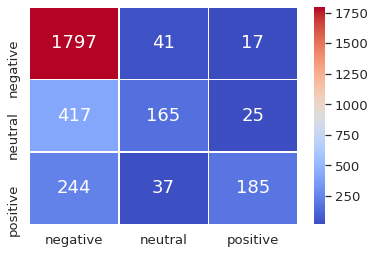

negative 0.7550932845662839
neutral 0.6284511377033845
positive 0.7091359479539646


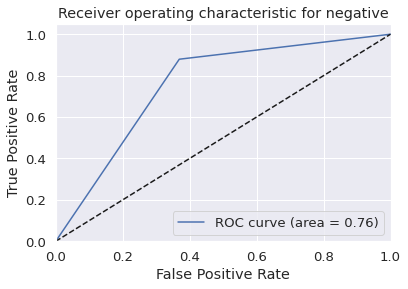

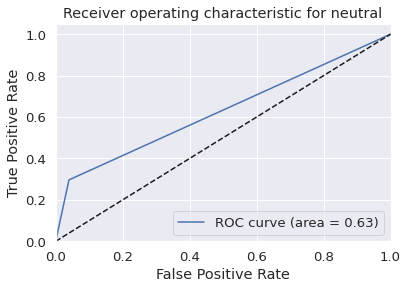

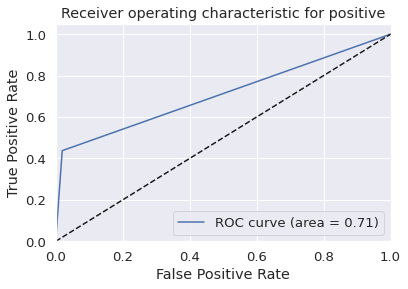

In [135]:
y_pred_svm = clf_svm.predict(X_dev_vec)
show_eval(y_dev_lb, y_pred_svm, lb_trained, svm )